
# Multi-Layer Neural Networks for Classification

Course: ITCS 4156 - Introduction to Machine Learning 

Instructor: Xiang Zhang

$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\tv}{\mathbf{t}}
 \newcommand{\bv}{\mathbf{b}}
 \newcommand{\av}{\mathbf{a}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Im}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}}
 \newcommand{\Am}{\mathbf{A}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

<br/>
<font color="blue"><b>

NAME: *Shardul Ladekar*

</b> </font>

## Goal 
The goal of this lab will be to practice implementing the feed-forward and feedback processes for multi-layer neural networks. Further, we'll look at how we can reformulate neural networks to work for classification problems. Finally, we'll also take a look at more systematic hyper-parameter tuning using Sklearn's `GridSearchCV` class. To do so, once again, we'll work with Sign Language MNIST dataset which is a data set for classifying images of The American Sign Language of hand gestures..

Your job is to read through the lab and fill in any code segments that are marked by `TODO` headers and comments. **It should be noted, that all the correct outputs are given below each code cell. It might be useful to duplicate all the `TODO` cells so you can try to match the correct output with your own code!**

Use the `todo_check()`to help guide you in understanding whether your code for a given TODO is correct or incorrect. However, failing a TODO check doesn't mean you won't receive points, though it could be a good indication. If you are failing feel free to ask and we can help check what is happening.

## Agenda
- Review and load the Sign Language MNIST dataset via Sklearn
- Visualize and explore the Sign Language MNIST dataset
- Create the data preparation pipeline where we apply data preprocessing AFTER splitting
- Implement a simple multi-layer neural networks for multi-class classification problems
    - Implement ReLU, and softmax activation functions.
    - Implement the multi-layer neural network feed-forward process for making predictions
    - Implement the  multi-layer neural network feedback process for updating the weights and biases
- Investigate hyper-parameters tuning by using cross validation with grid search

## Table of notation

| Symbol                     | Meaning                     | Symbol    | Meaning                                                          |
|----------------------------|-----------------------------|-----------|------------------------------------------------------------------|
| $\xv$ or $\vec{x}$         | feature/input vector        | $x_i$     | $i$th element of $\xv$                                           |
| $\Xm$                      | input matrix                | $x_{i,j}$ | $i$th row and $j$th column of $\Xm$                              |
| $\yv$ or $\tv$             | labels/targets              | $n$       | number of features or columns 
| $\wv$ or $\mathbf{\theta}$ | weight/parameter vector     | $m$       | number of data samples <br>(also used to refer to the slope) |samples or rows                                   |
| $f$ or $h$                 | hypothesis function <br> (i.e., a model)        | $\hat{\yv}$ <br> $f(\xv {;} \wv)$<br>$h(\xv {;} \wv)$ | predictions <br> y-hat |
| $E$              | error or sum of error (loss)  | $SSE$      | sum of squared error function                                            |
| $MSE$                      | mean squared error| $\nabla$  | gradient (nabla)                                       |
| $\partial$                 | partial derivative          | $\alpha$  | learning rate (alpha)                                  |       
| $J$ | general placeholder for <br>the objective function | $x^T$| transpose of a vector or matrix |
$b$ | bias or y-intercept term | $T$ | Threshold |
$*$| element-wise<br> multiplication | $\cdot$ | dot product|
| $z$<br>$\zv$| value before applying activation function |  $X, Y$ | Random variables |
| $K$| number/set of classes | $k$ | current class|
| $MLE$|  maximum likelihood estimation | $ML$ |  maximum likelihood|
| $MLL$|  maximum log likelihood | $LL$ | log likelihood |
| $L$|  likelihood | $NLL$ | negative log likelihood |
| $g$<br>$g'$ | activation function<br>activation function derivative | $a$/$h$ <br> $\av/\mathbf{h}$<br>$\Am$/$\mathbf{H}$ | output of activation function <br> or neuron
$w$<br>$\wv$<br>$\Wm$ | weights| $z$<br>$\zv$<br>$\Zm$ | linear combination output|
|$\Wm^{[l]}$| $l$th layer weights| $\Am^{[l]}$| $l$th layer activations
|$\Zm^{[l]}$| $l$th layer linear combinations| $\bv^{[l]}$| $l$th layer bias

## Imports 

In [2]:
import os
import warnings
import gc
from typing import Tuple, Union, List, Dict

import sklearn
sklearn_version = '1.0'
# Check to make sure you have the right version of sklearn
assert sklearn.__version__  > sklearn_version, f'sklearn version is only {sklearn.__version__} and needs to be > {sklearn_version}'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

np.set_printoptions(suppress=True) 
%matplotlib inline

In [3]:
# Set this to True if you DO NOT want to run the 
# garbage_collect() functions throughout the notebook
turn_off_garbage_collect = False

def garbage_collect(vars_):
    if not turn_off_garbage_collect:
        for v in vars_:
            if v in globals():
                del globals()[v]
        collected = gc.collect()

def todo_check(condi_err):
    failed_err = "You passed {}/{} and FAILED the following code checks:{}"
    failed = ""
    n_failed = 0
    for check, (condi, err) in enumerate(condi_err):
        if not condi:
            n_failed += 1
            failed += f"\nFailed check [{check+1}]:\n\t Tip: {err}"

    if len(failed) != 0:
        passed = len(condi_err) - n_failed
        err = failed_err.format(passed, len(condi_err), failed)
        raise AssertionError(err.format(failed))
    print("Your code PASSED the code check!")

# Problem statement summary

## Sign Language MNIST dataset problem summary

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F357637%2F6237b2fd781887e7c9e09ef6b7dc610b%2Famer_sign2.png?generation=1608488019646176&alt=media">

As mentioned, the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset is a dataset of 24 sign language hand gesture images where the goal is to classify each image as the correct letter. Read the below summary from Kaggle for a more in-depth description of the data. 

>The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).
>
>The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. 
>
>The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

Take note of the following important aspects about the data:

1. The data is already split such that there are 27k training samples and 7K testing examples.
1. The data features correspond to 784 pixels which means the images are 28x28. Often, it is best practice to flatten the 2D images into a single 1D array such that the width multiplied by the height determines the number of features (i.e., pixels).
1. Pixel values are gray scale and range from 0-255.
1. There are 24 classes, one for each letter in the alphabet excluding (J and Z).
1. The dataset largely consists of augmented images which means different augmentations were applied to the images to create new images. This is a common practice when working with image data as it can greatly increase the number of data samples.

# Data downloading and loading

The first step will be downloading the data. You have two options to download the data:

1. Download the data from the Canvas submission page for this lab
2. Download the data from [Kaggle](https://www.kaggle.com/datamunge/sign-language-mnist). 
    1. To download click on the "Download" button right under the Sign Language MNIST banner.
    2. In order to download the data, you'll need to sign into a Kaggle account. 
    3. Once downloaded, you'll want to extract the `sign_mnist_train.csv` and `sign_mnist_test.csv`files from the zip and put them in the same directory as this notebook.

#### TODO 1
Complete the TODO by loading the training data from the `sign_mnist_train.csv` file and the testing data from the `sign_mnist_test.csv` file.

1. Load training data for the Sign Language MNIST dataset using the Pandas and the `sign_mnist_train.csv` file. Store the output into the `asl_trn_df` variable.


2. Load testing data for the Sign Language MNIST dataset using the Pandas and the `sign_mnist_test.csv` file. Store the output into the `asl_tst_df` variable.

In [4]:
if not os.path.exists("sign_mnist_train.csv") and not os.path.exists("sign_mnist_test.csv") :
    warnings.warn(f"One or both of the sign_mnist_*.csv was not detected in your local path " \
                 f"{os.getcwd()}")   
# TODO 1.1
asl_trn_df = pd.read_csv("sign_mnist_train.csv")
# TODO 1.2
asl_tst_df = pd.read_csv("sign_mnist_test.csv")

todo_check([
    (type(asl_trn_df) is pd.DataFrame, "asl_trn_df is not a DataFrame"),
    (asl_trn_df.shape == (27455, 785), 'asl_trn_df does not have the shape (27455, 785)'),
    (type(asl_tst_df) is pd.DataFrame, "asl_tst_df is not a DataFrame"),
    (asl_tst_df.shape == (7172, 785), 'asl_tst_df does not have the shape (7172, 785)'),
])

Your code PASSED the code check!


Below is the DataFrame for the training data. 

In [5]:
asl_trn_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


Below is the DataFrame for the testing data.

In [6]:
asl_tst_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


# Data Visualization and Exploration

Once again, let's start off by getting a feel for the Sign Language MNIST dataset. To do so, we'll analyze the values, features, and shape of the data. Further, we'll do some quick visualizes of what the sign language hand gesture images look like.

Below we print out the shapes for the all the features in the training and testing sets. Notice, the class labels for each data sample can be accessed through the 'label' column while the rest of the columns correspond to pixels/features.

In [7]:
print(f"Shape of training data: {asl_trn_df.shape}")
print(f"Shape of training labels: {asl_trn_df['label'].shape}")

print(f"Shape of testing data: {asl_tst_df.shape}")
print(f"Shape of testing labels: {asl_tst_df['label'].shape}")

Shape of training data: (27455, 785)
Shape of training labels: (27455,)
Shape of testing data: (7172, 785)
Shape of testing labels: (7172,)


In [8]:
class_labels = np.unique(asl_trn_df['label'])

class_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

Recall, we'll store all the unique labels in the data are given by `class_labels`. Keep the `class_labels` variable in mind as we'll need to it in order to get the REAL class labels for our predictions later on.

How do we know which label corresponds to which sing language letter? Well, if you do some digging through the Sign Language MNIST dataset Kaggle website you'll find each letter simply corresponds to its numerical position where A starts a 0 and Z ends at 25. The below dictionary gives you the mapping of letters to class labels.

Keep in mind, the letters J (corresponding to label 9) and Z (corresponding to label 25) are dropped as their sign language hand gesture requires motion which we can't capture with images. Thus, they are not included in the dataset.

In [9]:
class_names = { 
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
    7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O',
    15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V',  
    22: 'W',23: 'X', 24: 'Y'
}

print(f"Total number of classes: {len(class_names)}")

Total number of classes: 24


Once again, let's go ahead and visualize some random data samples from each class to remind ourselves of what the data looks like.

Remember, the `display_classes()` function  defined below visualizes random samples from each class. It displays `n_samples` per each unique class in our data. Thus, if `n_samples=5` then 5 random samples for each class will be displayed. However, instead of using a Pandas DataFrame we are going to be using good ol' Matplotlib.

Take a second to look through the code. It's a little complex so if you have any questions be sure to ask!

In [10]:
import math

def display_classes(
    images: np.ndarray, 
    labels:np.ndarray,
    class_names: dict = None,
    shape: tuple=(28,28),
    n_samples=5):
    """ Displays random samples from MNIST classes 
        
        Args:
            images: A NumPy array where each row is a data sample and
                each column corresponds to a pixel location.
                
            labels: A NumPy array where each row corresponds to an
                image label.
                
            shape: 2D Shape of the images. By default each data sample in images 
                should be a flattened array.
                
            n_samples: Number of samples to display 
                
    """
    if class_names is None:
        class_names = {}
        
    # Get the unique class labels
    class_labels = np.unique(labels)
    # Compute the total number of images to plot
    plot_n_images = len(class_labels) * n_samples
    
    n_cols = n_samples
    # Compute the number of rows and round up
    n_rows = math.ceil(plot_n_images / n_cols)
    # Define subplot 
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    # Plot images
    for i, label in enumerate(class_labels):
        # Find all class locations
        all_class_locs = np.where(labels==label)[0]
        # Randomly choose class data samples
        selected_class_locs = np.random.choice(all_class_locs, n_samples, replace=False)
        # Plot label/name per row
        curr_class_name = class_names.get(label, label)
        axs[i, 0].set_ylabel(f"Class: {curr_class_name}", size='large')
        
        for j, cls_loc in enumerate(selected_class_locs):
            # Reshape image into width x height
            img = images[cls_loc].reshape(shape)
            # Plot image
            axs[i,j].imshow(img, cmap=plt.cm.gray)
            # Disable x and y ticks
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

Checkout the output we get when we run the `display_classes()` function below. Note the following:

- The y-axis gives the class name.

- Images for each class will look relatively similar. Remember, this dataset is mainly filled with augmented images. This means that the dataset started with very few data samples for each class and then different image augmentations such as rotations, lighting changes, crops, and others were applied to the images to create new images!

In [11]:
def run_display_classes(asl_df):

    images = asl_df.drop('label', axis=1).values
    labels = asl_df['label'].values

    display_classes(
        images, 
        labels, 
        class_names, 
        shape=(28,28),
        n_samples=5
    )


Random training data samples are given below.

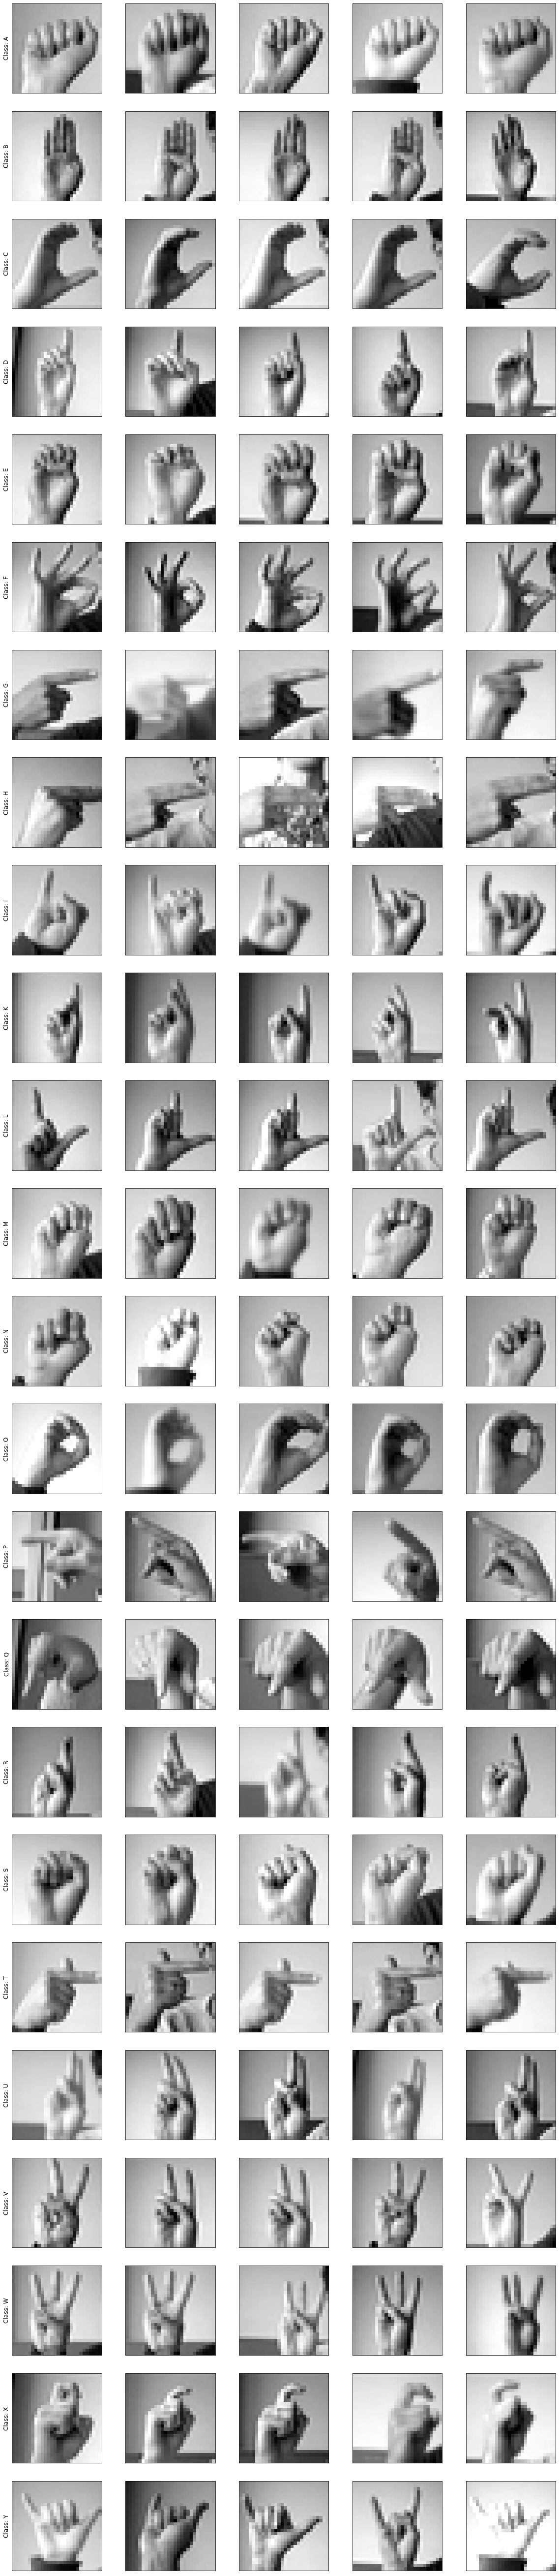

In [12]:
run_display_classes(asl_trn_df)

Random test data samples are given below.

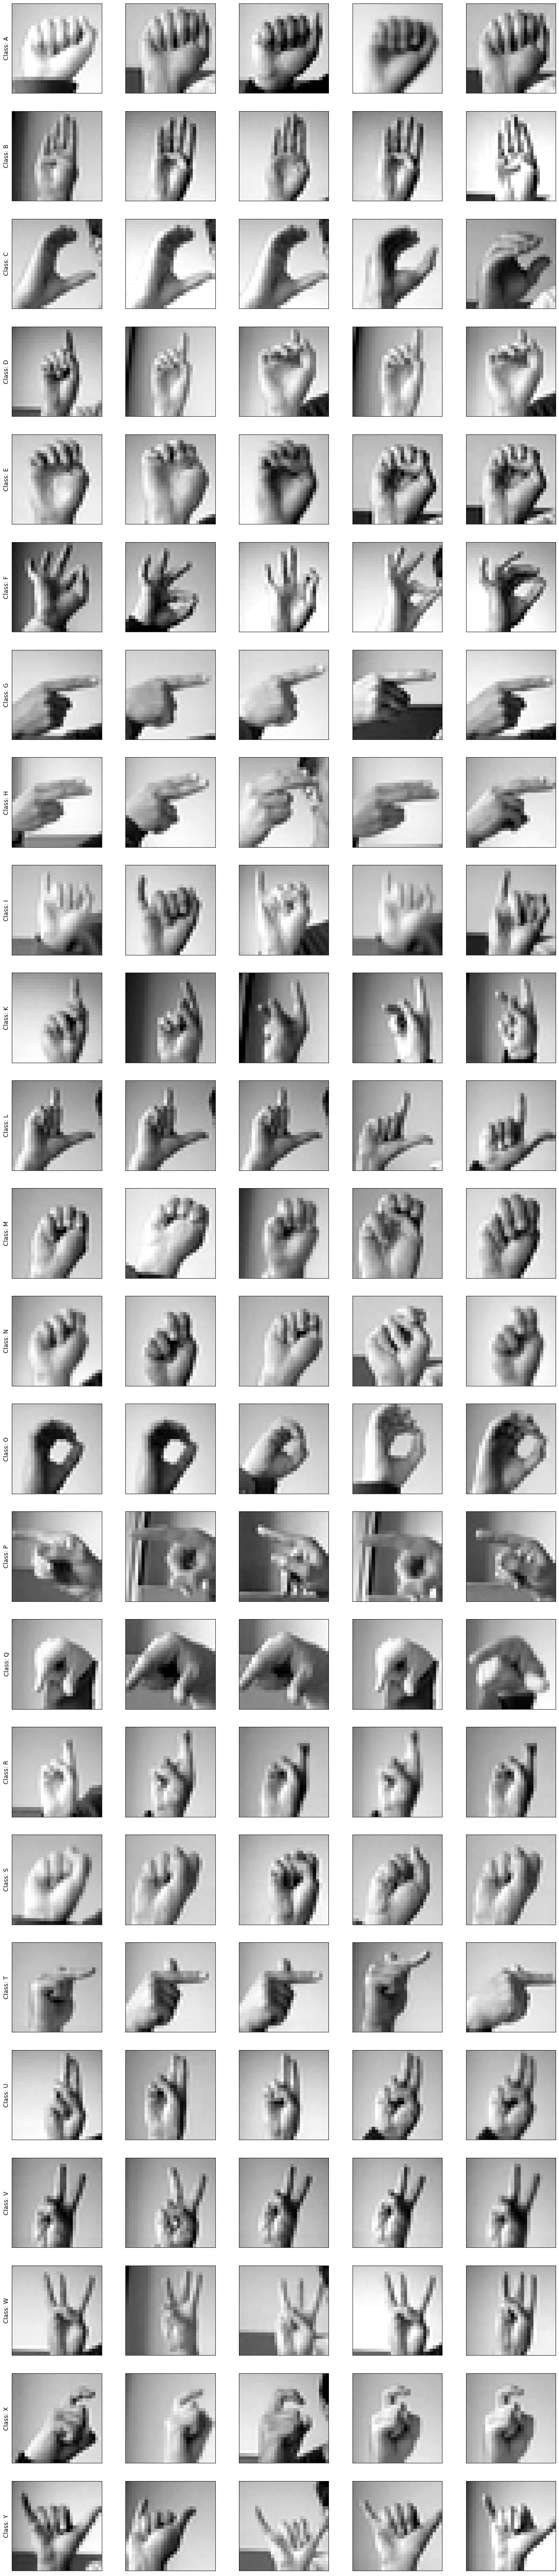

In [13]:
run_display_classes(asl_tst_df)

# Data Preparation Pipeline

Now it's time to recreate our data preparation pipelines we used in prior weeks. In this lab we will, once again, apply all our data cleaning and transformation operations AFTER splitting the data, since the data is technically partly split already. 


## Feature-label splitting

Below, are the splitting functions we'll be using once again to split our data. 

In [14]:
def feature_label_split(df: pd.DataFrame, 
                        label_name: str) -> Tuple[pd.DataFrame]:
    """ Split dataframe into features and labels
    
        Args:
            df: DataFrame containing both features and labels
            
            label_name: Name of the column which contains the labels
    """
    
    X = df.drop(label_name, axis=1)
    y = df[[label_name]].copy()
    
    return X, y

Notice, we need to split both the training and testing data since the features and labels are given in the same CSV.

In [15]:
def TEST_feature_label_split_train():
    X, y = feature_label_split(asl_trn_df, label_name='label')
    display(X)
    display(y)
    
TEST_feature_label_split_train()
garbage_collect(['TEST_feature_label_split_train'])

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


,label
0,3
1,6
2,2
3,2
4,13
...,...
27450,13
27451,23
27452,18
27453,17


In [16]:
def TEST_feature_label_split_test():
    X, y = feature_label_split(asl_tst_df, label_name='label')
    display(X)
    display(y)
    
TEST_feature_label_split_test()
garbage_collect(['TEST_feature_label_split_test'])

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,135,119,108,102,105,99,61,103,121,133,...,108,112,116,114,118,180,184,176,167,163
7168,157,159,161,164,166,166,171,174,175,176,...,213,213,213,214,213,211,210,210,209,208
7169,190,191,190,191,190,190,192,192,191,192,...,216,215,213,214,214,213,210,211,209,208
7170,201,205,208,209,214,216,218,223,226,229,...,112,169,255,255,237,113,91,67,70,63


,label
0,6
1,5
2,10
3,0
4,3
...,...
7167,1
7168,12
7169,2
7170,4


## Train-validation splitting
As we already have a test set. We only need to split the training set into a validation set. Thus, we define the `train_valid_split()` function to split data into train and validation sets.

In [17]:
from sklearn.model_selection import train_test_split

def train_valid_split(X, y, test_size=.2, seed=42):
    X_trn, X_vld, y_trn, y_vld = train_test_split(X, y, test_size=test_size, random_state=seed)

    return X_trn, y_trn, X_vld, y_vld

In [18]:
def TEST_train_valid_split():
    # Split into features and labels
    X_trn, y_trn = feature_label_split(asl_trn_df, label_name='label')
    # Split into train, validation, and test sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn)

    print(f"X_trn shape: {X_trn.shape}")
    print(f"y_trn shape: {y_trn.shape}")
    print(f"X_vld shape: {X_vld.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    
TEST_train_valid_split()
garbage_collect(['TEST_train_valid_split'])

X_trn shape: (21964, 784)
y_trn shape: (21964, 1)
X_vld shape: (5491, 784)
y_vld shape: (5491, 1)


## Transforming and cleaning data

In this lab, we'll need to first clean our labels/targets by converting them to a one-hot encoding using our `OneHotEncoding` class from previous labs. In regards to feature cleaning, all we need to do is standardize the data (recall for neural networks we are going to treats the bias as a separate parameter we need to learn, thus we don't need to add a column of bias terms to our data).

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

### Target cleaning
Below is the `OneHotEncoding` class using in prior labs. Recall, we'll use this class when using the softmax activation function only!

In [20]:
from sklearn.preprocessing import OneHotEncoder


class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names='auto'):
        self.feature_names = feature_names
        self.encoder = OneHotEncoder(categories=feature_names, sparse=False)

    def fit(self, X: pd.DataFrame):
        
        self.encoder.fit(X)
        
        # Store names of features
        self.feature_names = self.encoder.get_feature_names_out()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        
        one_hot =  self.encoder.transform(X)

        return pd.DataFrame(one_hot, columns=self.get_feature_names_out())
    
    def get_feature_names_out(self, name=None)-> pd.Series:
        return self.feature_names

Below we provide the `target_pipeline()` for you.

In [21]:
def target_pipeline(
    y_trn: pd.DataFrame,
    y_vld: pd.DataFrame,
    y_tst: pd.DataFrame
) ->  List[pd.DataFrame]:
    """ Creates Pipeline to apply data cleaning and transformations 
        to the targets/labels.
        
        Args:
            y_trn: train labels
            
            y_vld: validation labels
            
            y_tst: test labels
    """

    target_pipe = Pipeline([
        ('one-hot', OneHotEncoding())
    ])

    y_trn_clean = target_pipe.fit_transform(y_trn)
    y_vld_clean = target_pipe.transform(y_vld)
    y_tst_clean = target_pipe.transform(y_tst)
    
    return y_trn_clean, y_vld_clean, y_tst_clean


In [22]:
def TEST_target_pipeline():
    # Split data into features and labels
    X_trn, y_trn = feature_label_split(asl_trn_df, label_name='label')
    X_tst, y_tst = feature_label_split(asl_tst_df, label_name='label')
    # Split into train, validation, and test sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn)
    # Clean targets
    y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)

    print(f"y_trn shape: {y_trn.shape}")
    print(f"y_vld shape: {y_vld.shape}")
    print(f"y_tst shape: {y_tst.shape}")

    display(y_trn)
    
TEST_target_pipeline()
garbage_collect(['TEST_target_pipeline'])

y_trn shape: (21964, 24)
y_vld shape: (5491, 24)
y_tst shape: (7172, 24)


,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_10,...,label_15,label_16,label_17,label_18,label_19,label_20,label_21,label_22,label_23,label_24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21960,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature cleaning

The only feature cleaning classes we'll need is our `Standardization` class which we redefine for you below.

In [23]:
class Standardization(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-6):
        self.epsilon = epsilon
    
    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: pd.DataFrame = None):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
    
    def transform(self, X):
        X = (X  - self.mean) / (self.std + self.epsilon)
        return X.astype(np.float32) 

Below we provide the `feature_pipeline()` for you.

In [24]:
def feature_pipeline(
    X_trn: pd.DataFrame,
    X_vld: pd.DataFrame,
    X_tst: pd.DataFrame, 
) -> List[pd.DataFrame]:
    """ Creates Pipeline to apply data cleaning and transformations 
        to the input features of our data.
        
        Args:
            X_trn: train features
            
            X_vld: validation features
            
            X_tst: test features
    """
    feature_pipe = Pipeline([
        ('standard', Standardization()),
    ])
    
    X_trn_clean = feature_pipe.fit_transform(X_trn)
    X_vld_clean = feature_pipe.transform(X_vld)
    X_tst_clean = feature_pipe.transform(X_tst)
    
    return X_trn_clean, X_vld_clean, X_tst_clean

In [25]:
def TEST_feature_pipeline():
    # Split data into features and labels
    X_trn, y_trn = feature_label_split(asl_trn_df, label_name='label')
    X_tst, y_tst = feature_label_split(asl_tst_df, label_name='label')
    # Split into train, validation, and test sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn)
    # Apply feature cleaning AFTER splitting
    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst)

    print(f"X_trn shape: {X_trn.shape}")
    print(f"X_tst shape: {X_tst.shape}")
    display(X_trn)
    
TEST_feature_pipeline()
garbage_collect(['TEST_feature_pipeline'])

X_trn shape: (21964, 784)
X_tst shape: (7172, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
22706,-1.176200,-2.098060,-0.600129,-2.854492,-3.760392,-2.532840,-2.758344,-2.866820,-2.909831,-2.994114,...,0.746585,0.491823,-0.305828,-0.978212,-1.352838,-1.213103,-1.089376,-1.139868,-1.099969,-1.066928
1231,1.679378,1.688488,1.682091,1.801566,1.339504,0.483779,0.440272,0.848864,-1.776970,-1.394759,...,-0.131832,-0.226706,-0.336871,-0.428980,-0.442787,-0.614019,0.061683,-0.602116,-2.167454,-0.306548
531,-0.038809,-0.091942,-0.138556,-0.175308,-0.171576,-0.235782,-0.273705,-0.340155,-0.399166,-0.499120,...,-0.994564,-0.624191,0.454717,0.434099,0.137762,-0.046466,-0.505963,-0.443953,-0.942986,-1.361770
21099,-1.974794,-1.897448,-1.754061,-1.501894,-1.493772,-1.398149,-1.416068,-1.410272,-1.409555,-1.394759,...,0.338749,0.293081,0.237418,0.151636,0.122072,0.158483,0.156290,0.204513,0.218689,0.252099
17752,-1.514997,-1.521301,-2.420777,-2.048135,-1.493772,-3.363102,-4.100621,-2.955997,-2.909831,-2.930140,...,-0.853390,-1.174554,-1.578577,-1.009597,0.326049,0.205779,0.266666,0.315227,0.359974,0.407279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,-0.643804,-0.718854,-0.779629,-0.825595,-0.819182,-0.650913,-0.473619,-0.221253,-0.092987,0.108634,...,0.197574,-0.058540,0.796186,0.983330,0.749693,0.631444,0.392809,-0.095996,-0.487735,-0.446209
5390,0.808185,0.785735,0.758946,0.735095,0.745866,0.732858,0.640185,0.640785,0.641842,0.620428,...,-0.790645,-1.679053,-1.764833,-1.527444,-1.494053,-1.354991,-1.026304,-1.029154,-1.366840,-1.672129
860,1.146982,1.136806,1.117947,1.125267,1.150619,1.147989,1.182808,1.205569,1.223581,1.228183,...,-0.210262,-0.318434,-0.414477,-0.491750,-0.552621,-0.598254,-0.616338,-0.649564,-0.644718,-0.663461
15795,1.316381,1.312341,1.220519,1.151279,1.150619,1.120313,1.125690,1.116393,1.101110,1.004273,...,-0.461239,-1.220417,-1.671705,0.418406,0.122072,-0.882030,-0.726713,-0.554667,-1.413935,-1.547985



## Putting it all together

In order to make our lives easier we create a function called `data_prep()` which will split our data into the target/feature and apply data cleaning and transformations for us. Thus, whenever we go to implement a new algorithm we can call `data_prep()` to give us our data and override any other variables with the same names!

**Take time to also read the DocStrings or in-line documentation, given at the start of the function, which describes what each argument does. You need to understand what each argument does before moving forward!**

Note: Any arguments in a function given after the `*` in the function definition below MUST be passed using the keyword. See this [post](https://stackoverflow.com/questions/14301967/bare-asterisk-in-function-arguments) for more information.

In [26]:
def data_prep(
    trn_df: pd.DataFrame,
    tst_df: pd.DataFrame,
    label_name: str,
    *,
    seed: int = 42,
    return_array: bool = False,
) -> Tuple[pd.DataFrame]:
    """ Splits data and runs data cleaning and transformations.
    
        Args:
            trn_df: A Pandas DataFrame containing the training dataset 
                for the current lab.
                
            tst_df: A Pandas DataFrame containing the testing dataset 
                for the current lab.
                
            label_name: Name of the column in the DataFrame which
                will be used as the label/target. This will be passed
                to the feature_label_split() function.
            
            seed: The seed used when splitting data into train, 
                validation, and test. This will be passed to the
                train_valid_test_split() function.
            
            return_array: A boolean which when True will return all data as NumPy
                arrays instead of Pandas DataFrames.
    """
    # Apply feature and label splitting
    X_trn, y_trn = feature_label_split(trn_df, label_name=label_name)
    X_tst, y_tst = feature_label_split(tst_df, label_name=label_name)
    
    # Split into train and validation sets
    X_trn, y_trn, X_vld, y_vld = train_valid_split(X_trn, y_trn, seed=seed)
    
    # Target cleaning
    y_trn, y_vld, y_tst = target_pipeline(y_trn, y_vld, y_tst)
    
    # Feature cleaning
    X_trn, X_vld, X_tst = feature_pipeline(X_trn, X_vld, X_tst)

    # Resets the Pandas index for the Dataframe and series
    # This will prevent any headaches when combining or indexing
    # our train, validation, and test data in the future.
    X_trn.reset_index(inplace=True, drop=True)
    y_trn.reset_index(inplace=True, drop=True)
    X_vld.reset_index(inplace=True, drop=True)
    y_vld.reset_index(inplace=True, drop=True)
    X_tst.reset_index(inplace=True, drop=True)
    y_tst.reset_index(inplace=True, drop=True)
        
    # Return data as arrays instead of DataFrames
    if return_array:
        X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = (X_trn.values, 
                                                    y_trn.values, 
                                                    X_vld.values, 
                                                    y_vld.values, 
                                                    X_tst.values, 
                                                    y_tst.values)                  
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

#### TODO 2
Complete this TODO by calling `data_prep()` function as specified below.

1. Call the `data_prep()` so that it will return the Sign Language MNIST train, validation, and test data formatted as NumPy arrays. Do so by passing the arguments which correspond to the following:
    1. Pass any required arguments (i.e., arguments with no default values).
    1. Return all data as NumPy arrays.

In [27]:
# TODO 2.1
data = data_prep(trn_df=asl_trn_df, tst_df=asl_tst_df, label_name='label', return_array=True)
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

print(f"X_trn type: {type(X_trn)}")
print(f"X_trn shape: {X_trn.shape}")
print(f"y_trn shape: {y_trn.shape}")
print(f"X_vld shape: {X_vld.shape}")
print(f"y_vld shape: {y_vld.shape}")
print(f"X_tst shape: {X_tst.shape}")
print(f"y_tst shape: {y_tst.shape}")

todo_check([
    (type(X_trn) is np.ndarray,"X_trn is not a NumPy Array"),
    (y_trn.shape == (21964, 24), "y_trn does not have the shape 21964, 24)"),
    (y_vld.shape == (5491, 24), "y_vld does not have the shape (5491, 24)"),
    (y_tst.shape == (7172, 24), "y_tst does not have the shape (7172, 24)"),
])

X_trn type: <class 'numpy.ndarray'>
X_trn shape: (21964, 784)
y_trn shape: (21964, 24)
X_vld shape: (5491, 784)
y_vld shape: (5491, 24)
X_tst shape: (7172, 784)
y_tst shape: (7172, 24)
Your code PASSED the code check!


# Defining Classification Metrics and Plots

Before we get to our algorithms, let's first define the metrics and plots we'll be using to assess how good predictions are. 

### Accuracy
Below we redefine the `accuracy()` function which you defined in last module's lab.

In [28]:
 def accuracy(y, y_hat):
    # Convert y from one-hot encoding back to normal
    if len(y.shape) > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=1).reshape(-1,1)
    # Make sure y is 2D
    elif len(y.shape) == 1:
        y = y.reshape(-1, 1)
    # Make sure y_hat is 2D
    if len(y_hat.shape) == 1:
        y_hat = y_hat.reshape(-1, 1)

        
    total_correct = np.sum(y_hat == y)
    total_samples = len(y)
    print(f"Accuracy ratio: {total_correct}/{total_samples}")
    return total_correct / total_samples

### Confusion Matrix

Keep in mind, we will be looking at multi-class classification which means the confusion matrix will be a 3x3 since we have 3 classes. Recall the confusion for **binary classification** looked like the below image.

<img src="http://www.andrewgurung.com/wp-content/uploads/2018/12/confusion_matrix.png" width=500 height=500>


The below image is what a **multi-class classification confusion matrix** looks like. Further, the below image shows how to determine the false positives, true positives, false negatives, and true negatives for each class. More on this later in the lab.


<img src="https://i.stack.imgur.com/AuTKP.png" width=300 height=300>


In [29]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y, y_hat, class_names=None, figsize=(6, 4)):
    # Convert y from one-hot encoding back to normal
    if len(y.shape) > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=1).reshape(-1,1)

    cfm = confusion_matrix(y_pred=y_hat, y_true=y)

    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes

    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    fig, ax = plt.subplots(figsize=figsize)  
    sns.heatmap(cfm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Acutal', fontsize=14)
    return cfm

### Other scores

Below we define functions for the positive predictive value (PPV) or precision, True positive rate (TPR) or recall, and true negative rate (TNR) or specificity.

$$
\text{PPV} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

$$
\text{TNR} = \frac{\text{TN}}{\text{TN} + \text{FP}}
$$

Lastly, we define `compute_scores()` which will automatically compute the PPV, TPR, and TNR scores for each class using the multi-class confusion matrix.

In [30]:
def ppv(tp, fp):
    return tp / (tp + fp)

def tpr(tp, fn):
    return tp / (tp + fn)

def tnr(tn, fp):
    return tn / (tn + fp)

def compute_scores(y, y_hat, class_names=None):
    def print_scores(tn, fn, fp, tp):

        print(f"\tPPV ratio tp/(tp+fp): {tp}/{tp+fp}")
        print(f"\tPPV (precision): {ppv(tp=tp, fp=fp) }\n")

        print(f"\tTPR ratio tp/(tp+fn): {tp}/{tp+fn}")
        print(f"\tTPR (recall/sensitivity): {tpr(tp=tp, fn=fn)}\n")

        print(f"\tTNR ratio tn/(tn+fp): {tn}/{tn+fp}")
        print(f"\tTNR (specificity): {tnr(tn=tn, fp=fp)}")
    
    if class_names is None:
        class_names = {}
    
    # Convert y from one-hot encoding back to normal
    if len(y.shape) > 1 and y.shape[-1] > 1:
        y = np.argmax(y, axis=1).reshape(-1,1)
    # Make sure y is 2D
    elif len(y.shape) == 1:
        y = y.reshape(-1, 1)
    # Make sure y_hat is 2D
    if len(y_hat.shape) == 1:
        y_hat = y_hat.reshape(-1, 1)
    
    cm = confusion_matrix(y_true=y, y_pred=y_hat)
    
    # Computing multi-class classification tp, fn, tp, tn
    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    
    ppv_ = ppv(tp=tp, fp=fp) 
    tpr_ = tpr(tp=tp, fn=fn)
    tnr_ = tnr(tn=tn, fp=fp)
    
    class_labels = np.unique(y)
    
    if len(class_labels) == 2:
        class_name = class_names.get(class_labels[-1], class_labels[-1])
        print(f"Scores for binary problem: positive label is {class_name}")
        print_scores(tn[-1], fn[-1], fp[-1], tp[-1])
    else:
        for i, label in enumerate(class_labels):
            class_name = class_names.get(label, label)
            print(f"Scores for class {class_name}")
            print_scores(tn[i], fn[i], fp[i], tp[i])

    return ppv_, tpr_, tnr_

# Multi-Layer Neural Networks
Let's get onto adapting the existing neural network code to work with multiple layers. Recall, multi-layer refers to having more than one hidden layer.

The below image is a simplified neural network schematic designed to match the dimensions of the Sign Language MNIST dataset. In this section we are going to build the below neural network schematic. Notice the following about the below image:

- The image displays no weights in order to reduce clutter. However, keep in mind that every layer is still FULLY CONNECTED to the next layer!

- For simplicity, we will only added 2 hidden layers with 2 hidden neurons. This allows us to create one of the simplistic multi-layer neural networks.

- There are 784 inputs $x$ corresponding to the 784 features (i.e., pixels) for each data sample in the Sign Language MNIST dataset.

- There are 24 outputs $\hat{y}_\text{prob}$ corresponding to the 24 predicted probabilities for each classes.



<img src="https://live.staticflickr.com/65535/52002190784_5c2ed874eb_h.jpg" width="2646" height="1444" alt="ASL_MNIST_nn">

## Activation Functions

Before we can implement neural networks we need to define our activation functions we'll be using in this lab. Recall each neuron can have an activation function. **The KEY element of neurons in neural networks are non-linear activation functions.** By introducing non-linearity with non-linear activation functions, neural networks are able to learn more complex non-linear models. In this section we are only going to implement the Softmax and ReLU activation functions.

Below are classes who have two static methods `activation()` and `derivative()`. Here the  `activation()`  static method computes the equation of the activation function while the `derivative()` static method computes the derivative of the activation function. We'll use the `activation()` static method for the feed-forward processes and the `derivative()` static method for the feedback process.

*Note: If you don't know what a static method is, see this [post](https://pythonbasics.org/static-method/)*

### Softmax

Recall, the softmax activation function is an activation function that squashes values into probabilities such that the new values lie between 0 and 1 and the sum of all the new values is 1. 


**Activation equation**

Once again, the softmax equation is given as follows:

$$
\begin{align}
g(z)= \frac{e^{\zv_i}}{\sum_{k=1}^K e^{\zv_k}}
\end{align}
$$
where each output neuron requires access to the linear combination $\zv$ of every other output neuron in order to compute the sum $\sum_{k=1}^K e^{\zv_k}$.

**Derivative equation**

The derivative of the softmax is actually rather complex as it depends on multiple linear combinations from multiple output neurons. To keep things simple, we can combine the softmax with the NLL to get a very easy to compute derivative. Instead of computing the derivative for the softmax and NLL separately we'll combine the softmax and NLL and then compute the derivative of the softmax and NLL together (we'll do something like [this](https://d2l.ai/chapter_linear-networks/softmax-regression.html#softmax-and-derivatives) shortly). Thus, we'll set the `derivative()` static method to return an array of 1s which acts as a placeholder derivative. When used in backpropagation, this will act as if no derivative was taken applied for the activation function.


#### TODO 3

Complete the TODO by implementing the `activation()` and `derivative()` static methods for the `Softmax`.

1. Implement the `activation()` by implementing the softmax equation given above. Return the output of the equation.


2. Implement the `derivative()` method to which outputs a placeholder derivative for the softmax. To do so, simply return an array of ones that is the same shape as the input `z`.

In [31]:
class Softmax():
    @staticmethod
    def activation(z):
        # TODO 3.1
        z = z - np.max(z, axis=0, keepdims=True)
        e_z = np.exp(z)
        denominator = np.sum(e_z, axis=0, keepdims=True)
        return e_z/denominator
    
    @staticmethod
    def derivative(z):
        # TODO 3.2
        return np.ones(z.shape)

Run the below `TEST_softmax()` function to test your implementation of the `Softmax` class.

In [32]:
def TEST_softmax():
    z = np.array([
        [5, 7, 10],
        [12, 3, 5]
    ])
    print(f"z BEFORE softmax:\n{z}")
    y_soft = Softmax.activation(z.T).T
    print(f"z AFTER softmax:\n{y_soft}")
    print(f"z AFTER softmax sum:\n{y_soft.sum(axis=1, keepdims=True)}")
    
    todo_check([
        (y_soft.shape == (2, 3), "y_soft shape is incorrect"),
        (np.isclose(y_soft[0, 0], 0.00637746, rtol=.01),"y_soft values are incorrect"),
    ])
    
TEST_softmax()
garbage_collect(['TEST_softmax'])

z BEFORE softmax:
[[ 5  7 10]
 [12  3  5]]
z AFTER softmax:
[[0.00637746 0.04712342 0.94649912]
 [0.99896578 0.00012328 0.00091094]]
z AFTER softmax sum:
[[1.]
 [1.]]
Your code PASSED the code check!


### ReLU

In order to address the issues of tanh and the sigmoid activation functions the *Rectified Linear Unit* (ReLU) which squashes values between 0 and infinity (notice [ReLU is unbounded in the positive direction](https://stackoverflow.com/questions/53191284/numpy-overflow-in-calculations-disrupting-code), thus it can suffer from overflow errors when values are too large). The ReLU activation function was developed for its convenient mathematical properties which allow the gradient to be computed quickly. Furthermore, as we'll see shortly and in the deep learning section, ReLU is the go to activation function when stacking multiple hidden layers.


**Activation equation**

The ReLU activation function equation is given as follows:

$$
\begin{align}
g(z) &= \max(0, z)\\
\end{align}
$$

**Derivative equation**

The derivative of the ReLU activation is given as follows:

$$
\begin{align}
g'(z) &= \begin{cases}
    & 1 \quad  \text{if} \, z \ge 0\\
    & 0 \quad  \text{if} \, z < 0\\
\end{cases}
\end{align}
$$

#### TODO 4

Complete the TODO by implementing the `activation()` and `derivative()` static methods for the `ReLU` class.

1. Implement the `activation()` method by implementing the ReLU equation given above. Return the output of the equation.


2. Implement the `derivative()` method implementing the derivative of the ReLU equation given above. Return the output of the equation.
    1. Hint: Make sure to copy `z` if you use the method shown in the notes!

In [33]:
class ReLU():
    @staticmethod
    def activation(z):
        # TODO 4.1
        return np.maximum(0, z)
    
    @staticmethod
    def derivative(z):
        # TODO 4.2
        z = z.copy()
        z[z>=0] = 1
        z[z<0] = 0
        return z

Run the below `TEST_relu()` function to test your implementation of the `ReLU` class.

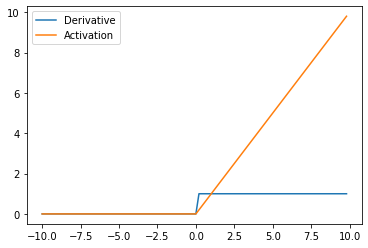

Your code PASSED the code check!


In [34]:
def TEST_relu(): 
    x = np.arange(-10, 10 , .2)
    y = ReLU.activation(x)
    dy = ReLU.derivative(x)

    plt.plot(x ,dy, label='Derivative')
    plt.plot(x ,y, label='Activation')
    plt.legend()
    plt.show();

    todo_check([
        (np.isclose(y.sum(), 244.9999, rtol=.01), "y has incorrect values"),
        (np.isclose(dy.sum(), 49.0, rtol=.01),  "derivative of y `dy` has incorrect values"),
    ])
    
TEST_relu()
garbage_collect(['TEST_relu'])

## Layer Class

First, we need to start by defining a `Layer` class. Doing so will help our code to be more easily generalizable and organized  going forward. The `Layer` class will keep track of the number of neurons, number of inputs, weights, biases, activation function, linear combination output, and activation output for a given layer.

Before moving on, read the documentation for the attributes in the `Layer` class below. The only method the `Layer` class has is the `print_info()` method which will print a summary of all attributes contained within the class.

In [35]:
class Layer():
    """Class for all variables required by a layer
    
        Attributes:
            W: NumPy array of weights for all neurons in the layer
            
            b: NumPy array of biases for all neurons in the layer
            
            g: Activation function for all neurons in the layer
            
            name: Name of the layer
            
            neurons: Number of neurons in the layer
            
            inputs: Number of inputs into the layer
            
            Z: Linear combination of weights and inputs for all neurons. 
                Initialized to an empty array until it is computed and set.
                
            A: Activation output for all neurons. Initialized to an empty 
                array until it is computed and set.
    """
    def __init__(
        self, 
        W:np.array, 
        b:np.array, 
        g: object, 
        name: str="Layer"
    ):
        self.W = W
        self.b = b
        self.g = g
        self.name = name 
        self.neurons = len(W)
        self.inputs = W.shape[1]
        self.Z = np.array([])
        self.A = np.array([])
    
    def print_info(self):
        """ Prints infor for all class attributes """
        print(f"{self.name}")
        print(f"\tNeurons: {self.neurons}")
        print(f"\tInputs: {self.inputs}")
        print(f"\tWeight shape: {self.W.shape}")
        print(f"\tBias shape: {self.b.shape}")
        print(f"\tActivation function: {self.g.__name__}")
        print(f"\tZ shape: {self.Z.shape}")
        print(f"\tA shape: {self.A.shape}")

## Initializing Weights and Biases

The first step, before performing the forward pass, is to initialize the structure of the neural network by initializing the weight and bias parameters for each layer.

#### TODO 5
Complete the TODO by implementing the `init_weights()` function which initializes weight values using random uniform distribution.

1. Initialize the weights for a layer using the input arguments of `neurons` and `inputs` and return the output. To do so, use the following tips:
    1. Weights should ALWAYS have the shape (neurons, inputs). Think about what the inputs are and how many neurons the layer has.
    1. Use the NumPy's `np.random.uniform()` function ([docs](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html)) to randomly generate the weight matrix of shape (neurons, inputs). The weight values should be restricted between the range of -0.5 (minimum) and 0.5 (maximum). 

In [36]:
def init_weights(neurons: int, inputs: int):
    """ Initializes weight values using random uniform distribution
    
        Args:
            neurons: Number of neurons in the layer
            
            inputs: Number of inputs to the layer
    """
    # TODO 5.1
    return np.random.uniform(low=-0.5, high=0.5, size=(neurons, inputs))

Run the below `TEST_init_weights()` function to test your implementation of the `init_weights()` function.

In [37]:
def TEST_init_weights(times=100):
    all_W = []
    for t in range(times):
        fake_W = init_weights(10, 100)
        all_W.append(fake_W)
    all_W = np.concatenate(all_W)

    todo_check([
        (fake_W.shape == (10, 100), "fake_W has the wrong weight shapes"),
        (np.all((all_W > -0.5) & (all_W < 0.5)), "Weight values are not between -0.5 and 0.5")
    ])
    
TEST_init_weights()
garbage_collect(["TEST_init_weights"])

Your code PASSED the code check!


#### TODO 6
Complete the TODO by finishing the implementation of the `init_neural_network()` function which initializes the a weights and biases for a multi-layer neural network. 

**Be sure to read the documentation inside the function to understand what each variable does.** If you need additional explanations see the notes or ask!

1. Determine the input for the the current layer based on the current the for-loop iteration. To do so, define the following if...else statement:
    1. `if` the current layer index `l` corresponds to the 1st hidden layer index, set `inputs` equal to the number of inputs features.
    1. `else` the current layer is NOT the 1st hidden layer, set `inputs` equal to the number of outputs in the previous layer. 
        1. Hint: Try indexing `neurons_per_layer`.
       
       
2. Initialize the weights for the current layer in the for-loop iteration. To do so, use the the `init_weights()` function. Store the output into `W`.


3. Initialize the biases for the current layer in the for-loop iteration. Store the output into `b`. To do so, use the following tips:
    1. The biases should be a vector of all 1s with the shape (neurons, 1). Try using `np.ones()` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.ones.html)).
    
    
4. Initialize an instance of the `Layer` class for the current layer in the for-loop iteration. To do so, pass all the required arguments and the name of the layer, given by `name`. Store the output into `layer`.

In [38]:
def init_neural_network(
    n_input_features: int, 
    neurons_per_layer: List[int], 
    g_hidden: object, 
    g_output: object, 
    seed=0
)-> List[Layer]:
    """ Initializes weights and biases for a multi-layer neural network 
    
        Args:
            n_input_features: Number of features the input data has
            
            neurons_per_layer: A list where each element represents 
                the neurons in a layer. For example, [2, 3] would
                create a 2 layer neural network where the hidden layer
                has 2 neurons and the output layer has 3 neurons.
                
            g_hidden: Activation function used by ALL neurons 
                in ALL hidden layers.
                
            g_output: Activation function used by ALL neurons
                in the output layer.
                
            seed: Determines global seed to use when initalizing 
                weights.
    """
    nn = []
    # Set the seed to get reproducible intial weight values
    np.random.seed(seed)
    for l, neurons in enumerate(neurons_per_layer):
        # TODO 6.1
        if l == 0:
            inputs = n_input_features
        else:
            inputs = neurons_per_layer[l-1]
        # Set activation functions for the output
        # layer neurons and set the names of the nn
        # g: stores current layer's activation function
        # name: stores the current layer's human readable name
        if l == len(neurons_per_layer)-1:
            g = g_output
            name = f"Layer {l+1}: Output Layer"
        else:
            g = g_hidden
            name = f"Layer {l+1}: Hidden Layer"
        
        # TODO 6.2
        W = init_weights(neurons, inputs)
        
        # TODO 6.3
        b = np.ones([neurons, 1])
        
        # TODO 6.4
        layer = Layer(W=W, b=b, g=g, name=name)
        nn.append(layer)
        
    return nn

Run the below code to test your implementation of the `init_neural_network()` function where we define a neural network with matches our neural network schematic given below. 

Take note that `neurons_per_layer` argument is a list of integers where each element corresponds to the number of neurons in the layer. The means, the total number of elements corresponds to the total number of layers one wishes to create a neural network with. Further, the last element always corresponds to the number of neurons in the output layer. 

For example, `neurons_per_layer=[2, 2, 24]` creates a 3 layer neural network where the 1st hidden layer has 2 neurons, the 2nd hidden layer has 2 neurons, and the output layer has 24 neurons.


<img src="https://live.staticflickr.com/65535/52002190784_5c2ed874eb_h.jpg" width="2646" height="1444" alt="ASL_MNIST_nn">

In [39]:
neurons_per_layer = [2 ,2, 24]
g_hidden = ReLU
g_output = Softmax

nn = init_neural_network(
    n_input_features=X_trn.shape[1], 
    neurons_per_layer=neurons_per_layer,
    g_hidden=g_hidden,
    g_output=g_output
)

todo_check([
    (len(nn) == 3, "nn has the wrong length"),
    (nn[0].W.shape == (2, 784), "1st hidden layer weight shapes are incorrect"),
    (nn[0].b.shape  == (2, 1), "1st hidden layer bias shapes are incorrect"),
    (nn[1].W.shape  == (2, 2), "2nd hidden layer weight shapes are incorrect"),
    (nn[1].b.shape  == (2, 1), "2nd hidden layer bias shapes are incorrect"),
    (nn[2].W.shape  == (24, 2), "Output layer weight shapes are incorrect"),
    (nn[2].b.shape  == (24, 1), "Output layer bias shapes are incorrect"),
])

Your code PASSED the code check!


Below is the output of the `init_neural_network()` function. Notice, it is a list of `Layer` class instances where we have 3 layers: one for the 1st hidden layer, one for the 2nd hidden layer, and one for the output layer. These layers are given in order from 1st hidden layer to output layer.

In [40]:
nn

We can loop over all the `Layer` class instances in `nn` to print the attribute information using the `print_info()` method. Notice, the 1st hidden layer corresponds to element 0, the 2nd hidden layer corresponds to element 1, and the output layer corresponds to element 2. Lastly, notice, `Z`, the linear combination of weights and inputs, and `A`, the output of the neuron, for each layer are empty arrays as they have not yet been computed. Recall, these will be compute during the forward pass!

In [41]:
for layer in nn:
    layer.print_info()

Layer 1: Hidden Layer
	Neurons: 2
	Inputs: 784
	Weight shape: (2, 784)
	Bias shape: (2, 1)
	Activation function: ReLU
	Z shape: (0,)
	A shape: (0,)
Layer 2: Hidden Layer
	Neurons: 2
	Inputs: 2
	Weight shape: (2, 2)
	Bias shape: (2, 1)
	Activation function: ReLU
	Z shape: (0,)
	A shape: (0,)
Layer 3: Output Layer
	Neurons: 24
	Inputs: 2
	Weight shape: (24, 2)
	Bias shape: (24, 1)
	Activation function: Softmax
	Z shape: (0,)
	A shape: (0,)


## Multi-Layer Forward Pass

Time to adapt our new neural network code to perform the feed-forward process for multiple layers. The forward pass or feed-forward process is relatively simple. Recall, every layer uses the same 2 equations to compute the linear combinations $\Zm$ and activation outputs $\Am$.
$$
\Zm^{[\text{layer}]} = \Wm^{[\text{layer}]} \Am^{[\text{layer}-1]} + \bv^{[\text{layer}]}
$$

$$
\Am^{[\text{layer}]} = g(\Zm^{[\text{layer}]})
$$
where $\Am^{[0]} = \Xm$. **Here it will be helpful to about interpret $\text{layer}$  in $\Am{^{[\text{layer}]}}$/$\Zm{^{[\text{layer}]}}$/$\Wm{^{[\text{layer}]}}$ as the current layer that is being updated in the forward pass process (i.e., each iteration of the for-loop). Thus, $\text{layer}-1$ can be thought of as the previous layer (i.e., previous iteration of the for-loop).**

Since we utilize the same two equations for each layer, we can generalize the code by implementing a `forward()` function which applies the above two equations to each layer in our neural network by creating a for-loop that loops over the list of `Layer` class instances stored in `nn`. Additionally, the loop sets the linear combination variable `linear.Z` and activation output variable `linear.A` for each layer.

 The following is how each code variable in the `forward()` function will map to the variables in the equations: 
- `layer` corresponds to $\text{layer}$
- `layer.W` corresponds to $\Wm^{[\text{layer}]}$
- `layer.b` corresponds to $\bv^{[\text{layer}]}$
- `A` corresponds to $\Am^{[\text{layer}-1]}$ and represents the current layer's input (i.e., the previous layer's output)
- `layer.Z` corresponds to $\Zm^{[\text{layer}]} $
- `layer.g.activation(layer.Z)` corresponds to $g(\Zm^{[\text{layer}]})$
- `layer.A` corresponds to $\Am^{[\text{layer}]} $ the output of the current layer



#### TODO 7
Complete the TODO by finishing the `forward()` function which performs the forward pass for a multi-layer neural network.


**Before the loop**

1. Start by setting `A` equal to the the transpose of the input features `X`. Recall `A` will act as the input for each layer and will be updated for each iteration of the for-loop!

**Inside the loop**

2. Compute $\Zm^{[\text{layer}]}$ the current layer's linear combination between the layer's inputs and weights. Store the output into the current layer's $\Zm^{[\text{layer}]}$ variable given by `layer.Z`.

$$
\Zm^{[\text{layer}]} = \Wm^{[\text{layer}]} \Am^{[\text{layer}-1]} + \bv^{[\text{layer}]}
$$

3. Compute $\Am^{[\text{layer}]}$ the current layer's activation output. Store the output into the current layer's $\Am^{[\text{layer}]}$  variable into `layer.A`. 

4. Update  `A`  to store the input for the next layer by storing the current layer's output `layer.A`.

**After the loop**

5. Store the transpose of the output of the neural network into `y_hat`. 
    1. Hint: Recall, `A` will be storing the output of the network (you can also think about this as the input for the loss function). Furthermore, remember, `A` here will have the shape (output neurons, data samples) so we need to transpose it to get (data samples, output neurons) which matches the ground truth shape for `y` which is (data samples, classes). Here, the output layer has a neuron for each class such that the number output layer neurons equals the number of classes.

In [42]:
def forward(X:np.ndarray, nn: List[Layer], verbose: bool = False):
    """ Performs the forward pass for a multi-layer neural network
    
        Args:
            X: Input features. This should be typically be the 
                training data.
            
            nn: List of Layer class instances which together 
                define a nueral network. 
            
            verbose: If True then information regarding eqation shapes
                will be printed for each layer.
    
    """
    # TODO 7.1
    A = X.T
    
    # layer: the current Layer class instance
    # l: the index position of layer in the nn list
    for l, layer in enumerate(nn):
        
        # TODO 7.2
        layer.Z = layer.W @ A + layer.b
        if verbose:  print(f"Z{l+1}{layer.Z.shape} = W{l+1}{layer.W.shape} @ A{l}{A.shape} + b{l+1}{layer.b.shape}")
        
        # TODO 7.3
        layer.A = layer.g.activation(layer.Z)
        if verbose: print(f"A{l+1}{layer.A.shape} = g(Z{l+1}{layer.Z.shape})")
        
        # TODO 7.4
        A = layer.A
        
    # TODO 7.5
    y_hat = A.T
    return y_hat

Run the below code to test your implementation of the `forward()` function.

Notice, we added some useful print statements which print the shapes of all the variables and their corresponding variable name and layer number. For example, "W1" in the print statements corresponds to the shape for weights in the 1st hidden layer and "A0" corresponds to the shape of the input features which act as inputs into the 1st hidden layer. Thus, the number after each variable corresponds to the layer number.

In [43]:
y_hat_probs = forward(X_trn, nn, verbose=True)

todo_check([
    (y_hat_probs.shape == (21964, 24), "y_hat_probs has the wrong shape"),
    (np.isclose(nn[0].Z[0, 0], 8.29492345, rtol=.01), "1st hidden layer has incorrect Z values"),
    (np.isclose(nn[0].A[0, 0], 8.29492345, rtol=.01), "1st hidden layer has incorrect A values"),
    (np.isclose(nn[2].Z[0, 0], 0.5277135, rtol=.01), "2nd hidden layer has incorrect Z values"),
    (np.isclose(nn[2].A[0, 0], 0.01902055, rtol=.01), "2nd hidden layer has incorrect A values"),
])

Z1(2, 21964) = W1(2, 784) @ A0(784, 21964) + b1(2, 1)
A1(2, 21964) = g(Z1(2, 21964))
Z2(2, 21964) = W2(2, 2) @ A1(2, 21964) + b2(2, 1)
A2(2, 21964) = g(Z2(2, 21964))
Z3(24, 21964) = W3(24, 2) @ A2(2, 21964) + b3(24, 1)
A3(24, 21964) = g(Z3(24, 21964))
Your code PASSED the code check!


Below we can see the output transformed by the softmax activation function giving us the probability that each data sample belongs to a given class.

In [44]:
y_hat_probs

array([[0.01902055, 0.00858561, 0.05921423, ..., 0.08747698, 0.00889091,
        0.01045515],
       [0.01203956, 0.00399601, 0.05813763, ..., 0.09986916, 0.00419438,
        0.0052512 ],
       [0.02536399, 0.01411603, 0.03604656, ..., 0.05785986, 0.03549318,
        0.01782481],
       ...,
       [0.01693732, 0.0066681 , 0.05033411, ..., 0.08722703, 0.01085709,
        0.00877691],
       [0.02536399, 0.01411603, 0.03604656, ..., 0.05785986, 0.03549318,
        0.01782481],
       [0.025394  , 0.01414364, 0.03616855, ..., 0.0579605 , 0.03534544,
        0.01784557]])

In [45]:
y_hat_probs.shape

(21964, 24)

Below we can see all the probabilities for each data sample sum to one!

In [46]:
y_hat_probs.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

If we loop over all the `Layer` class instances in `nn` to print the attribute information using the `print_info()` method again we can see that `Z` and `A` have been set for each layer!

In [47]:
for layer in nn:
    layer.print_info()

Layer 1: Hidden Layer
	Neurons: 2
	Inputs: 784
	Weight shape: (2, 784)
	Bias shape: (2, 1)
	Activation function: ReLU
	Z shape: (2, 21964)
	A shape: (2, 21964)
Layer 2: Hidden Layer
	Neurons: 2
	Inputs: 2
	Weight shape: (2, 2)
	Bias shape: (2, 1)
	Activation function: ReLU
	Z shape: (2, 21964)
	A shape: (2, 21964)
Layer 3: Output Layer
	Neurons: 24
	Inputs: 2
	Weight shape: (24, 2)
	Bias shape: (24, 1)
	Activation function: Softmax
	Z shape: (24, 21964)
	A shape: (24, 21964)


### Computing the negative log likelihood (NLL) loss

As alway for classification problems, we need to  compute the negative log likelihood (NLL) loss. Below we define the `nll` which computes the cost over all data samples. Notice, that we add a small epsilon value to prevent any divide by zero errors/warnings.

In [48]:
def nll(y, y_hat_probs, epsilon=1e-5):
    loss = y * np.log(y_hat_probs+epsilon)
    cost = -np.sum(loss)
    return cost

In [49]:
cost = nll(y=y_trn, y_hat_probs=y_hat_probs)
cost

75942.01549529443

To compute the average NLL loss we simply divide by the total number of training data samples.

In [50]:
mean_loss = cost / len(y_trn)
mean_loss

3.457567633185869

## Multi-Layer Backward Pass

Now it's time to generalize our neural network backward pass using backpropagation to work for multiple layers as well! As mentioned in the notes, the generalization of the backpropagation code is where things begin to get slightly more ugly and complex. If you haven't, please review the *Multi-Layer Feedback: Backpropagation* from this modules notes and the *Backpropagation* section from the *Neural Networks: Regression* notes. We'll be assuming you have an idea of the notation and a gernal idea of how backpropagation works.

In this section, we will breakdown how to write the generalized `backward()` function. Further, before we do so, we will unfold the for-loop and compute each layer's derivative one at a time using the pattern/trick we learned about in the notes. 

Recall, **the main trick is to pass $\frac{\partial NLL}{\partial \Am^{[\text{layer}-1]}}$ the partial derivative of a layer with respect to its inputs onto the next layer in the backpropagation process.** Doing so will, reduce the redundant computations we have to make due to the same partial derivatives appearing over and over again as we move backwards through the network. See the notes for more information about this pattern/trick.

### Computing softmax and negative log likelihood (NLL) loss derivative

Before even getting the the backward pass code we need to first define the derivative of our loss function. Recall, we are using the NLL loss which means we need to compute its derivaitve.

However, recall, in order to simplify the derivative of the softmax we can compute the derivative of the softmax and NLL loss together. The reason why we did not compute the derivative of the softmax when we defined `Softmax` class above is because computing the derivative of the softmax, on its own, is rather complex. The derivate of the softmax actually has two cases where the derivative differs depending on the case.

However, we can account for both cases and therefore simplify the derivative by plugging in the softmax into the NLL loss function and then solving for the derivative. For a <u>single data sample</u>, the NLL loss with the softmax plugged into it would look like the following:

$$
NLL= -\yv \log \frac{e^{\hat{y}_i}}{\sum_{k=1}^K e^{\hat{y}_k}}
$$
where $\hat{y}_i = a^{[3]}_i = z^{[3]}_i$ in our 3 layer neural network.

By taking the derivative of the above equation we get the following:

$$
\frac{d NLL}{d \hat{\yv}} = (\hat{\yv} - \yv) 
$$
where $\hat{\yv}$ is vector of output probabilities (one probability for each class) for a single data sample and $\yv$ is a one-hot encoded vector.

#### TODO 8
Compute the TODO by implementing the `delta_softmax_nll()` function which computes the derivative of the softmax and NLL loss function together at once.

1. Convert the derivative equation for the softmax and NLL loss into code. Return the output of the equation. 

$$
\frac{d NLL}{d \hat{\yv}} = (\hat{\yv} - \yv) 
$$

In [51]:
# TODO 8.1
def delta_softmax_nll(y, y_hat_probs):
    return y_hat_probs - y

Run the below `TEST_delta_softmax_nll()` function to test your implementation of the `delta_softmax_nll()` function.

In [52]:
def TEST_delta_softmax_nll():
    fake_yoh = np.array([
        [0., 1., 0.],
        [0., 0., 1.]
    ])
    fake_probs = np.array([
        [.1, .5, .4],
        [.1, .2, .7],
    ])
    delta_sm_nll = delta_softmax_nll(y=fake_yoh, y_hat_probs=fake_probs)

    todo_check([
        (np.all(np.isclose(delta_sm_nll.flatten(), [ 0.1, -0.5,  0.4,  0.1,  0.2, -0.3], rtol=.01)), "delta_sm_nll has incorrect values"),
    ])
    
TEST_delta_softmax_nll()
garbage_collect(['TEST_delta_softmax_nll'])

Your code PASSED the code check!


### Output layer
As mentioned, before we write the generalized backward pass code, we will first unfold the loop. This means we will implement each iteration of the for-loop manually so we can more clearly see what is happening before we add more levels of abstraction by using a for-loop. 

Recall our network schematic is as follows:

<img src="https://live.staticflickr.com/65535/52002190784_5c2ed874eb_h.jpg" width="2646" height="1444" alt="ASL_MNIST_nn">

Thus, starting with the output layer, we can to compute the partial derivative of NLL with respect to $\Zm^{[3]}$ using our first shared terms $\frac{\partial NLL}{\partial \Am^{[3]}}\frac{\partial \Am^{[3]}}{\partial \Zm^{[3]}}$.

$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[3]}} &= \frac{\partial NLL}{\partial \Am^{[3]}}^\top \frac{\partial \Am^{[3]}}{\partial \Zm^{[3]}} \\
&= (\hat{\Ym}_{\text{prob}} - \Ym)^\top * g'(\Zm^{[3]})
\end{align}
$$
where $g'(\Zm^{[3]})$ is the derivative of the activation function for output layer's neurons and $\frac{\partial NLL}{\partial \Am^{[3]}} = \frac{\partial NLL}{\partial \hat{\Ym}_{\text{prob}}}$ is the partial derivative of the NLL loss with respect to the output of the network, which we already computed above.

Remember, $g'(\Zm^{[3]})$  would normally be the derivative of the softmax function. However, since we already computed it when we computed $\frac{\partial NLL}{\partial \Am^{[3]}}$ then $g'(\Zm^{[3]}) = \mathbf{1}$. Meaning, we set the softmax derivative to be a column vectors of 1s such that it WILL NOT influence our gradient equations! Thus, we can also just ignore it.

Finally, note $\hat{\Ym}_{\text{prob}}$ and $\Ym$ are matrices because $\hat{\Ym}_{\text{prob}}$contains multiple data samples and predicted probabilities for each class while $\Ym$ contains one-hot encodings for multiple data samples.

Using $\frac{\partial NLL}{\partial \Zm^{[3]}}$  we can compute the gradients for the weights $\Wm^{[3]}$ and biases $\bv^{[3]}$ as follows:

$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[3]}} &= \frac{\partial NLL}{\partial \Zm^{[3]}} \cdot \frac{\partial \Zm^{[3]}}{\partial \Wm^{[3]}} ^\top  \\
&= \frac{\partial NLL}{\partial \Zm^{[3]}} \cdot \Am^{[2]\top},
\end{align}
$$

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[3]}} &= \frac{\partial NLL}{\partial \Zm^{[3]}} \cdot \frac{\partial \Zm^{[3]}}{\partial \bv^{[3]}}^\top  \\
&= \frac{\partial NLL}{\partial \Zm^{[3]}}  \cdot \mathbf{1}^\top.
\end{align}
$$

Finally, we can compute the partial derivative of NLL with respect to the layer inputs $\Am^{[2]}$ by taking the dot product between $\frac{\partial NLL}{\partial \Zm^{[3]}}$ and $\frac{\partial \Zm^{[3]}}{\partial \Am^{[2]}}$ as given:

$$
\begin{align}
\frac{\partial NLL}{\partial \Am^{[2]}}& = \frac{\partial \Zm^{[3]}}{\partial \Am^{[2]}}^\top \cdot \frac{\partial NLL}{\partial \Zm^{[3]}} \\
&= \Wm^{[3]\top} \cdot \frac{\partial NLL}{\partial \Zm^{[3]}}
\end{align}
$$
where $\frac{\partial NLL}{\partial \Am^{[2]}}$ will be passed on and utilized by the next layer's gradient equations. **Now here is the big idea, pattern, or trick. Notice, for this and proceeding steps we always pass on the partial derivative of the NLL with respect to the current layers input's (i.e., previous layer's outputs) $\frac{\partial NLL}{\partial \Am^{[\text{layer-1}]}}$ to the next layer in the backpropagation process!**

#### TODO 9
Complete the TODO by performing the backpropagation step for the output layer. Use the below tables that map equation variables to code variables to help solve this TODO.

<font color='red'>**Refer to the notes if you are struggling!**</font> 

**Setting the current layer**
 
1. Set `output_layer` to store the element which corresponds to the output layer within `nn` the list of `Layer` class instances. 
    1. Hint: Recall, `nn` stores all the `Layer` class instances where the first element corresponds to the 1st hidden layer and the last element corresponds to the output layer.

**Computing `delta_A3` $\frac{\partial NLL}{\partial \Am^{[3]}}$**

2. Compute $\frac{\partial NLL}{\partial \Am^{[3]}}$ the partial derivative of the loss $NLL$ with respect to the neural network output $\hat{\Ym} = \Am^{[3]\top}$. Use the below equation for guidance Store the output into `delta_A3`.
    1. Hint: Be sure to transpose the solution to the partial derivative $\frac{\partial NLL}{\partial \Am^{[3]}}$ as neural networks require the shape (classes, data samples).
    
    $$
\begin{align}
\frac{\partial NLL}{\partial \Am^{[3]}} =  (\hat{\Ym}_{\text{prob}} - \Ym)^\top
\end{align}
$$

**Computing `delta_Z3` $\frac{\partial NLL}{\partial \Zm^{[3]}}$**
       

3. Compute $\frac{\partial NLL}{\partial \Zm^{[3]}}$ the partial derivative of the loss $NLL$ with respect to the linear combinations of weights and inputs for the output layer. Store the output into `delta_Z3`
    1. Hint: Use `delta_A3` which we computed in the previous TODO.
    
$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[3]}} &= \frac{\partial NLL}{\partial \Am^{[3]}}^\top \frac{\partial \Am^{[3]}}{\partial \Zm^{[3]}} \\
&= (\hat{\Ym}_{\text{prob}} - \Ym)^\top * g'(\Zm^{[3]})
\end{align}
$$

**Computing `delta_W3` $\frac{\partial NLL}{\partial \Wm^{[3]}}$ and `delta_b3` $\frac{\partial NLL}{\partial \bv^{[3]}}$**

4. Compute $\frac{\partial NLL}{\partial \Wm^{[3]}}$ the partial derivative of the loss $NLL$ with respect to the output layer weights. Store the output into `delta_W3`.
    1. Hint: Use `delta_Z3` which we computed in the previous TODO.


$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[3]}} &= \frac{\partial NLL}{\partial \Zm^{[3]}} \cdot \frac{\partial \Zm^{[3]}}{\partial \Wm^{[3]}}^\top  \\
&= \frac{\partial NLL}{\partial \Zm^{[3]}} \cdot \Am^{[2]\top},
\end{align}
$$


5. Compute $\frac{\partial NLL}{\partial \bv^{[3]}}$ the partial derivative of the loss $NLL$ with respect to the output layer biases. Store the output into `delta_b3`.
    1. Hint: Use `delta_Z3` which we computed in the previous TODO.
    1. Hint: You'll need to define an `np.ones()` array with shape (1, data samples) and transpose it to represent $\mathbf{1}^\top$. A second option is that you can just sum over `delta_Z3` and not include the vector of ones or the dot product.

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[3]}} &= \frac{\partial NLL}{\partial \Zm^{[3]}} \cdot \frac{\partial \Zm^{[3]}}{\partial \bv^{[3]}}^\top  \\
&= \frac{\partial NLL}{\partial \Zm^{[3]}}  \cdot \mathbf{1}^\top.
\end{align}
$$
**Computing `delta_A2` $\frac{\partial NLL}{\partial \Am^{[2]}}$**

6. Compute $\frac{\partial NLL}{\partial \Am^{[2]}}$ the partial derivative of the loss $NLL$ with respect to the output layer's inputs $\Am^{[2]}$. This partial derivative will be used to by the next layer in the backpropagation process. Store the output into `delta_A2`.
    1. Hint: Use `delta_Z3` which we computed in the previous TODO.

$$
\begin{align}
\frac{\partial NLL}{\partial \Am^{[2]}}& = \frac{\partial \Zm^{[3]}}{\partial \Am^{[2]}}^\top \cdot \frac{\partial NLL}{\partial \Zm^{[3]}} \\
&= \Wm^{[3]\top} \cdot \frac{\partial NLL}{\partial \Zm^{[3]}}
\end{align}
$$

In [182]:
# TODO 9.1
output_layer = nn[2]

layer.print_info()

todo_check([
    (output_layer.name == 'Layer 3: Output Layer', "output_layer has wrong name. Make sure you selected the output layer from nn."),
    (output_layer.neurons == 24, "output_layer has the wrong number of output neurons."),
])

Layer 3: Output Layer
	Neurons: 24
	Inputs: 2
	Weight shape: (24, 2)
	Bias shape: (24, 1)
	Activation function: Softmax
	Z shape: (24, 21964)
	A shape: (24, 21964)
Your code PASSED the code check!


In [155]:
print(f"delta_A3(24, 21964) = (y_hat_probs(21964, 24) - y(21964, 24))^T")

# TODO 9.2
delta_A3 = (y_hat_probs - y_trn).T
print(f"delta_A3 Shape: {delta_A3.shape}")

todo_check([
    (delta_A3.shape == (24, 21964), "delta_A3 has incorrect shape"),
    (np.all(np.isclose(delta_A3[0, :3], np.array([ 0.01902055,  0.01203956, -0.97463601]), rtol=.01)), "delta_A3 has incorrect values"),
])

delta_A3(24, 21964) = (y_hat_probs(21964, 24) - y(21964, 24))^T
delta_A3 Shape: (24, 21964)
Your code PASSED the code check!


In [159]:
print(f"delta_Z3(24, 21964) = delta_A3(24, 21964) * g'(Z3(24, 21964))")

# TODO 9.3
delta_Z3 = delta_A3 * Softmax.derivative(delta_A3)
print(f"delta_Z3 Shape: {delta_Z3.shape}")

todo_check([
    (delta_Z3.shape == (24, 21964), "delta_Z3 has incorrect shape"),
    (np.all(np.isclose(delta_Z3[0, :3], np.array([ 0.01902055,  0.01203956, -0.97463601]), rtol=.01)), "delta_Z3 has incorrect values")
])

delta_Z3(24, 21964) = delta_A3(24, 21964) * g'(Z3(24, 21964))
delta_Z3 Shape: (24, 21964)
Your code PASSED the code check!


In [245]:
print(f"delta_W3(24, 2) = delta_Z3(24, 21964) @ A2(2, 21964)^T")

# TODO 9.4
delta_W3 = delta_Z3 @ Softmax.activation(delta_A3).T
print(f"delta_W3 Shape: {delta_W3.shape}")

todo_check([
    (delta_W3.shape == (24, 2), "delta_W3 has incorrect shape"),
    (np.all(np.isclose(delta_W3[:3, 0], np.array([ 37.32041819, -330.15201929,   25.23538659]), rtol=.01)), "delta_W3 has incorrect values"),
])

delta_W3(24, 2) = delta_Z3(24, 21964) @ A2(2, 21964)^T
delta_W3 Shape: (24, 24)


AssertionError: You passed 0/2 and FAILED the following code checks:
Failed check [1]:
	 Tip: delta_W3 has incorrect shape
Failed check [2]:
	 Tip: delta_W3 has incorrect values

Below we compute the average weight gradient.

In [ ]:
W3_avg_grad = delta_W3 / len(y_trn)
print(f"W3 average gradient shape: {W3_avg_grad.shape}")

W3 average gradient shape: (24, 2)


In [ ]:
print(f"delta_b3(24, 1) = delta_Z3(24, 21964) @ 1(1, 21964)^T")

# TODO 9.5
delta_b3 =
print(f"delta_b3 Shape: {delta_b3.shape}")

todo_check([
    (delta_b3.shape == (24, 1), "delta_b3 has incorrect shape"),
    (np.all(np.isclose(delta_b3[:3], np.array([[-428.714],[-575.719],[ 120.967]]), rtol=.01)), "delta_b3 has incorrect values"),
])

delta_b3(24, 1) = delta_Z3(24, 21964) @ 1(1, 21964)^T
delta_b3 Shape: (24, 1)
Your code PASSED the code check!


Below we compute the average bias gradient.

In [ ]:
b3_avg_grad = delta_b3 / len(y_trn)
print(f"b3 average gradient shape: {b3_avg_grad.shape}")

b3 average gradient shape: (24, 1)


In [ ]:
print(f"delta_A2(2, 21964) = W3(24, 2)^T @ delta_Z3(24, 21964)")
# TODO 9.6
delta_A2 = 
print(f"delta_A2 Shape: {delta_A2.shape}")

todo_check([
    (delta_A2.shape == (2, 21964), "delta_A2 has incorrect shape"),
    (np.all(np.isclose(delta_A2[0, :3], np.array([-0.17170991, -0.35322078,  0.3286222 ]), rtol=.01)), "delta_A2 has incorrect values"),
])

delta_A2(2, 21964) = W3(24, 2)^T @ delta_Z3(24, 21964)
delta_A2 Shape: (2, 21964)
Your code PASSED the code check!


Using the gradients we can update the weights and biases.

In [ ]:
alpha = .01

output_layer_W = output_layer.W - alpha * W3_avg_grad
output_layer_b = output_layer.b - alpha * b3_avg_grad

In [ ]:
output_layer_W

array([[-0.18238512, -0.17018285],
       [-0.48015804, -0.45861651],
       [-0.2421898 ,  0.24006837],
       [ 0.12828053,  0.26928703],
       [ 0.26864753,  0.35588184],
       [ 0.22007348,  0.47770646],
       [ 0.39882941,  0.08634762],
       [ 0.08835016, -0.46543183],
       [ 0.49851207, -0.36764655],
       [ 0.24019181,  0.32038573],
       [-0.12676579, -0.30266708],
       [-0.40125143,  0.24837352],
       [-0.04741295,  0.21372759],
       [ 0.41540044, -0.35284351],
       [ 0.41916545, -0.08834976],
       [-0.19473793,  0.44177782],
       [ 0.49075854, -0.3005795 ],
       [ 0.15688462, -0.39269459],
       [ 0.15086542,  0.32657477],
       [ 0.18457183, -0.08242249],
       [-0.11684895, -0.1065296 ],
       [ 0.08964875,  0.38064993],
       [ 0.42912051, -0.44579756],
       [-0.3183132 , -0.38707663]])

In [ ]:
output_layer_b

array([[1.00019519],
       [1.00026212],
       [0.99994492],
       [0.99982964],
       [0.99957296],
       [0.99943854],
       [0.99991901],
       [1.00021296],
       [1.00019477],
       [0.99970365],
       [1.00026541],
       [0.99992083],
       [0.99993923],
       [1.00021737],
       [1.00005113],
       [0.99967193],
       [1.00021104],
       [1.00024127],
       [0.99975044],
       [1.00011469],
       [1.00015076],
       [0.99968914],
       [1.00022647],
       [1.00027654]])

### Hidden layer 2

Moving onto the 2nd or last hidden layer, we can to compute the partial derivative of NLL with respect to $\Zm^{[2]}$ using $\frac{\partial NLL}{\partial \Am^{[2]}}$ from the previous layer and $\frac{\partial \Am^{[2]}}{\partial \Zm^{[2]}}$ from the current layer.
$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[2]}} &= \frac{\partial NLL}{\partial \Am^{[2]}}\frac{\partial \Am^{[2]}}{\partial \Zm^{[2]}} \\
&=   \frac{\partial NLL}{\partial \Am^{[2]}} * g'(\Zm^{[2]})
\end{align}
$$
where $g'(\Zm^{[2]})$ is the derivative of the activation function for the neurons in last hidden layer. Thus, this is just the derivative of the ReLU activation function.

Using $\frac{\partial NLL}{\partial \Zm^{[2]}}$  we can compute the gradients for the weights $\Wm^{[2]}$ and biases  $\bv^{[2]}$ as follows:

$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[2]}} &= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot \frac{\partial \Zm^{[2]}}{\partial \Wm^{[2]}}^\top \\
&= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot \Am^{[1]\top},
\end{align}
$$

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[2]}} &= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot  \frac{\partial \Zm^{[2]}}{\partial \bv^{[2]}}^\top \\
&= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot \mathbf{1}^\top.
\end{align}
$$

Finally, we can compute the partial derivative of NLL with respect to the 2nd hidden layer's inputs $\Am^{[1]}$ by taking the dot product between $\frac{\partial NLL}{\partial \Zm^{[2]}}$ and $\frac{\partial \Zm^{[2]}}{\partial \Am^{[1]}}$ as given:

$$
\begin{align}
\frac{\partial NLL}{\partial \Am^{[1]}} &= \frac{\partial \Zm^{[2]}}{\partial \Am^{[1]}}^\top \cdot \frac{\partial NLL}{\partial \Zm^{[2]}} \\
&= \Wm^{[2]\top} \cdot \frac{\partial NLL}{\partial \Zm^{[2]}}
\end{align}
$$
where $\frac{\partial NLL}{\partial \Am^{[1]}}$ will be passed on and utilized by the next layer's gradient equations.

#### TODO 10
Complete the TODO by performing the backpropagation step for the 2nd hidden layer. Use the below tables that map equation variables to code variables to help solve this TODO.

<font color='red'>**Refer to the notes if you are struggling!**</font> 

**Setting the current layer**
 
1. Set `layer2` to store the element which corresponds to the 2nd hidden layer within `nn` the list of `Layer` class instances. 
    1. Hint: Recall, `nn` stores all the `Layer` class instances where the first element corresponds to the 1st hidden layer and the last element corresponds to the output layer.

**Computing `delta_Z2` $\frac{\partial NLL}{\partial \Zm^{[2]}}$**

2. Compute $\frac{\partial NLL}{\partial \Zm^{[2]}}$ the partial derivative of the loss $NLL$ with respect to the linear combinations of weights and inputs for the 2nd hidden layer. Store the output into `delta_Z2`
    1. Hint: Use `delta_A2` which we computed in TODO 9
    
$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[2]}} &= \frac{\partial NLL}{\partial \Am^{[2]}}\frac{\partial \Am^{[2]}}{\partial \Zm^{[2]}} \\
&=   \frac{\partial NLL}{\partial \Am^{[2]}} * g'(\Zm^{[2]})
\end{align}
$$

**Computing `delta_W2` $\frac{\partial NLL}{\partial \Wm^{[2]}}$ and `delta_b2` $\frac{\partial NLL}{\partial \bv^{[2]}}$**

3. Compute $\frac{\partial NLL}{\partial \Wm^{[2]}}$ the partial derivative of the loss $NLL$ with respect to the 2nd hidden layer weights. Store the output into `delta_W2`.
    1. Hint: Use `delta_Z2` which we computed in the previous TODO



$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[2]}} &= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot \frac{\partial \Zm^{[2]}}{\partial \Wm^{[2]}}^\top \\
&= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot \Am^{[1]\top},
\end{align}
$$


4. Compute $\frac{\partial NLL}{\partial \bv^{[2]}}$ the partial derivative of the loss $NLL$ with respect to the 2nd hidden layer biases. Store the output into `delta_b2`.
    1. Hint: Use `delta_Z2` which we computed in the previous TODO
    1. Hint: You'll need to define an `np.ones()` array with shape (1, data samples) and transpose it to represent $\mathbf{1}^\top$. A second option is that you can just sum over `delta_Z2` and not include the vector of ones or the dot product.

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[2]}} &= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot  \frac{\partial \Zm^{[2]}}{\partial \bv^{[2]}}^\top \\
&= \frac{\partial NLL}{\partial \Zm^{[2]}} \cdot \mathbf{1}^\top.
\end{align}
$$

**Computing `delta_A1` $\frac{\partial NLL}{\partial \Am^{[1]}}$**


5. Compute $\frac{\partial NLL}{\partial \Am^{[1]}}$ the partial derivative of the loss $NLL$ with respect to the 2nd hidden layer's inputs. This partial derivative will be used to by the next layer in the backpropagation process. Store the output into `delta_A1`.
    1. Hint: Use `delta_Z2` which we computed in the previous TODO

$$
\begin{align}
\frac{\partial NLL}{\partial \Am^{[1]}}& = \big ( \frac{\partial \Zm^{[2]}}{\partial \Am^{[1]}}  \big )^\top \cdot \frac{\partial NLL}{\partial \Zm^{[2]}} \\
&= \Wm^{[2]\top} \cdot \frac{\partial NLL}{\partial \Zm^{[2]}}
\end{align}
$$

In [239]:
# TODO 10.1
layer2 = nn[1]

layer2.print_info()

todo_check([
    (layer2.name == 'Layer 2: Hidden Layer', "layer2 has wrong name. Make sure you selected the 2nd hidden layer from nn."),
    (layer2.neurons == 2, "layer2 has the wrong number of hidden neurons."),
])

Layer 2: Hidden Layer
	Neurons: 2
	Inputs: 2
	Weight shape: (2, 2)
	Bias shape: (2, 1)
	Activation function: ReLU
	Z shape: (2, 21964)
	A shape: (2, 21964)
Your code PASSED the code check!


In [243]:
print(f"delta_Z2(2, 21964) = delta_A2(2, 21964) * g'(Z2(2, 21964))")

# TODO 10.2
delta_Z2 = delta_A3 * Softmax.derivative(delta_A3)
print(f"delta_Z2 Shape: {delta_Z2.shape}")

todo_check([
    (delta_Z2.shape == (2, 21964), "delta_Z2 has incorrect shape"),
    (np.all(np.isclose(delta_Z2[-1, -3:], np.array([0.5756628, 0.53552323, 0.15871728]))), "delta_Z2 has incorrect values"),
])

delta_Z2(2, 21964) = delta_A2(2, 21964) * g'(Z2(2, 21964))
delta_Z2 Shape: (21964,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(f"delta_W2(2, 2) = delta_Z2(2, 21964) @ A1(2, 21964)^T")

# TODO 10.3
delta_W2 =
print(f"delta_W2 Shape: {delta_W2.shape}")

todo_check([
    (delta_W2.shape == (2, 2),  "delta_W2 has incorrect shape"),
    (np.all(np.isclose(delta_W2[0], np.array([-12.65654051, 166.15485242]), rtol=.01)), "delta_W2 has incorrect values")
])

delta_W2(2, 2) = delta_Z2(2, 21964) @ A1(2, 21964)^T
delta_W2 Shape: (2, 2)
Your code PASSED the code check!


Below we compute the average weight gradient.

In [ ]:
W2_avg_grad = delta_W2 / len(y_trn)
print(f"W2 average gradient shape: {W2_avg_grad.shape}")

W2 average gradient shape: (2, 2)


In [ ]:
print(f"delta_b2(2, 1) = delta_Z2(2, 21964) @ 1(1, 21964)^T")

# TODO 10.4
delta_b2 =
print(f"delta_b2 Shape: {delta_b2.shape}")

todo_check([
    (delta_b2.shape == (2, 1), "delta_b2 has incorrect shape"),
    (np.all(np.isclose(delta_b2[:3], np.array([[426.635],  [4040.90]]), rtol=.01)), "delta_b2 has incorrect values"),
])

delta_b2(2, 1) = delta_Z2(2, 21964) @ 1(1, 21964)^T
delta_b2 Shape: (2, 1)
Your code PASSED the code check!


Below we compute the average bias gradient.

In [ ]:
b2_avg_grad = delta_b2 / len(y_trn)
print(f"b2 average gradient shape: {b2_avg_grad.shape}")

b2 average gradient shape: (2, 1)


In [ ]:
print(f"delta_A2(2, 21964) = W2(2, 2)^T @ delta_Z2(2, 21964)")
# TODO 10.5
delta_A1 =
print(f"delta_A1 Shape: {delta_A1.shape}")

todo_check([
    (delta_A1.shape == (2, 21964), "delta_A1 has incorrect shape"),
    (np.all(np.isclose(delta_A1[0, :3], np.array([-0.00849924,  0.0338268 , -0.02477116]), rtol=.01)), "delta_A1 has incorrect values"),
])

delta_A2(2, 21964) = W2(2, 2)^T @ delta_Z2(2, 21964)
delta_A1 Shape: (2, 21964)
Your code PASSED the code check!


Using the gradients we can update the weights and biases.

In [ ]:
alpha = .01

layer2_W = layer2.W - alpha * W2_avg_grad
layer2_b = layer2.b - alpha * b2_avg_grad

In [ ]:
layer2_W

array([[-0.1420103 , -0.06493366],
       [ 0.08560394,  0.21142467]])

In [ ]:
layer2_b

array([[0.99980576],
       [0.99816022]])

### Hidden layer 1


Moving onto with the 1st hidden layer, we can to compute the partial derivative of NLL with respect to $\Zm^{[1]}$ using $\frac{\partial NLL}{\partial \Am^{[1]}}$ from the previous layer and $\frac{\partial \Am^{[1]}}{\partial \Zm^{[1]}}$ from the current layer.

$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[1]}} &= \frac{\partial NLL}{\partial \Am^{[1]}}\frac{\partial \Am^{[1]}}{\partial \Zm^{[1]}} \\
&=   \frac{\partial NLL}{\partial \Am^{[1]}} * g'(\Zm^{[1]})
\end{align}
$$

where $g'(\Zm^{[1]})$ is the derivative of the activation function for 1st hidden layer's neurons which is the ReLU activation function.

Using $\frac{\partial NLL}{\partial \Zm^{[1]}}$  we can compute the gradients for the weights $\Wm^{[1]}$ and biases  $\bv^{[1]}$ as follows:

$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[1]}} &=  \frac{\partial NLL}{\partial \Zm^{[1]}} \cdot \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]}}^\top \\
&= \frac{\partial NLL}{\partial \Zm^{[1]}} \cdot \Am^{[0]\top},
\end{align}
$$

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[1]}} &=   \frac{\partial NLL}{\partial \Zm^{[1]}}  \cdot  \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]}} \\
&= \frac{\partial NLL}{\partial \Zm^{[1]}} \cdot \mathbf{1}^\top.
\end{align}
$$
where $\Am^{[0]} = \Xm$.

Since we have reached the first hidden layer, we no longer need to compute the partial derivative with respect to the current layer's input.

#### TODO 11
Complete the TODO by performing the backpropagation step for the 1st hidden layer. Use the below tables that map equation variables to code variables to help solve this TODO.

<font color='red'>**Refer to the notes if you are struggling!**</font> 


**Setting the current layer**
 
1. Set `layer1` to store the element which corresponds to the 1st hidden layer within `nn` the list of `Layer` class instances. 
    1. Hint: Recall, `nn` stores all the `Layer` class instances where the first element corresponds to the 1st hidden layer and the last element corresponds to the 1st hidden layer.

**Computing `delta_Z1` $\frac{\partial NLL}{\partial \Zm^{[1]}}$**

2. Compute $\frac{\partial NLL}{\partial \Zm^{[1]}}$ the partial derivative of the loss $NLL$ with respect to the linear combinations of weights and inputs for the 1st hidden layer. Store the output into `delta_Z1`
    1. Hint: Use `delta_A1` which we computed in TODO 10.
    
$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[1]}} &= \frac{\partial NLL}{\partial \Am^{[1]}}\frac{\partial \Am^{[1]}}{\partial \Zm^{[1]}} \\
&=   \frac{\partial NLL}{\partial \Am^{[1]}} * g'(\Zm^{[1]})
\end{align}
$$

**Computing `delta_W1` $\frac{\partial NLL}{\partial \Wm^{[1]}}$ and `delta_b1` $\frac{\partial NLL}{\partial \bv^{[1]}}$**

3. Compute $\frac{\partial NLL}{\partial \Wm^{[1]}}$ the partial derivative of the loss $NLL$ with respect to the 1st hidden layer weights. Store the output into `delta_W1`.
    1. Hint: Use `delta_Z1` which we computed in the previous TODO
    1. Hint: Try using `X_trn` with shape (data samples, features) or `A0` with shape (features, data samples) where `A0 = X_trn.T`.


$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[1]}} &=  \frac{\partial NLL}{\partial \Zm^{[1]}} \cdot \frac{\partial \Zm^{[1]}}{\partial \Wm^{[1]}}^\top \\
&= \frac{\partial NLL}{\partial \Zm^{[1]}} \cdot \Am^{[0]\top},
\end{align}
$$


4. Compute $\frac{\partial NLL}{\partial \bv^{[1]}}$the partial derivative of the loss $NLL$ with respect to the 1st hidden layer biases. Store the output into `delta_b1`.
    1. Hint: Use `delta_Z1` which we computed in the previous TODO
    1. Hint: You'll need to define an `np.ones()` array with shape (1, data samples) and transpose it to represent $\mathbf{1}^\top$. A second option is that you can just sum over `delta_Z1` and not include the vector of ones or the dot product.

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[1]}} &=   \frac{\partial NLL}{\partial \Zm^{[1]}}  \cdot  \frac{\partial \Zm^{[1]}}{\partial \bv^{[1]}} \\
&= \frac{\partial NLL}{\partial \Zm^{[1]}} \cdot \mathbf{1}^\top.
\end{align}
$$

In [ ]:
# TODO 11.1
layer1 =

layer1.print_info()

todo_check([
    (layer1.name == 'Layer 1: Hidden Layer', "layer1 has wrong name. Make sure you selected the 1st hidden layer from nn."),
    (layer1.neurons == 2, "layer1 has the wrong number of hidden neurons."),
])

Layer 1: Hidden Layer
	Neurons: 2
	Inputs: 784
	Weight shape: (2, 784)
	Bias shape: (2, 1)
	Activation function: ReLU
	Z shape: (2, 21964)
	A shape: (2, 21964)
Your code PASSED the code check!


In [ ]:
print(f"delta_Z1(2, 21964) = delta_A1(2, 21964) * g'(Z1(2, 21964))")

# TODO 11.2
delta_Z1 =
print(f"delta_Z1 Shape: {delta_Z1.shape}")

todo_check([
    (delta_Z1.shape == (2, 21964), "delta_Z1 has incorrect shape"),
    (np.all(np.isclose(delta_Z1[0, :3], np.array([-0.00849924,  0.0338268 , -0.]), rtol=.01)), "delta_Z1 has incorrect values"),
])

delta_Z1(2, 21964) = delta_A1(2, 21964) * g'(Z1(2, 21964))
delta_Z1 Shape: (2, 21964)
Your code PASSED the code check!


In [ ]:
print(f"delta_W1(2, 784) = delta_Z1(2, 21964) @ A0(784, 21964)^T")

A0 = X_trn.T

# TODO 11.3
delta_W1 =
print(f"delta_W1 Shape: {delta_W1.shape}")

todo_check([
    (delta_W1.shape == (2, 784), "delta_W1 has incorrect shape"),
    (np.all(np.isclose(delta_W1[0, :3], np.array([11.35838323,  5.78225958,  5.29613148]), rtol=.01)), "delta_Z1 has incorrect values"),
])

delta_W1(2, 784) = delta_Z1(2, 21964) @ A0(784, 21964)^T
delta_W1 Shape: (2, 784)
Your code PASSED the code check!


Below we compute the average weight gradient.

In [ ]:
W1_avg_grad = delta_W1 / len(y_trn)
print(f"W1 average gradient shape: {W1_avg_grad.shape}")

W1 average gradient shape: (2, 784)


In [ ]:
print(f"delta_b1(2, 1) = delta_Z1(2, 21964) @ 1(1, 21964)^T")

# TODO 11.4
delta_b1 =
print(f"delta_b1 Shape: {delta_b1.shape}")

todo_check([
    (delta_b1.shape == (2, 1), "delta_b1 has incorrect shape"),
    (np.all(np.isclose(delta_b1, np.array([[212.659], [687.138]]), rtol=.01)), "deltab1 has incorrect values"),
])

delta_b1(2, 1) = delta_Z1(2, 21964) @ 1(1, 21964)^T
delta_b1 Shape: (2, 1)
Your code PASSED the code check!


Below we compute the average bias gradient.

In [ ]:
b1_avg_grad = delta_b1 / len(y_trn)
print(f"b1 average gradient shape: {b1_avg_grad.shape}")

b1 average gradient shape: (2, 1)


Using the gradients we can update the weights and biases.

In [ ]:
alpha = .01

layer1_W = layer1.W - alpha * W1_avg_grad
layer1_b = layer1.b - alpha * b1_avg_grad

In [ ]:
layer1_W

array([[ 0.04880833,  0.21518673,  0.10276096, ..., -0.07310531,
         0.34284715,  0.31802343],
       [-0.39767211, -0.34370353, -0.19588569, ..., -0.16001108,
        -0.4315027 , -0.2711931 ]])

In [ ]:
layer1_b

array([[0.99990318],
       [0.99968715]])

### General backward pass

Now it's time to write the `backward()` which will generalize the previous backpropagation code by utilizing a for-loop. The main idea is use a for-loop to iterate over the layers in the neural network in the reverse order (output layer to 1st hidden layer). 

The `backward()` function can be summarized as follows where it will be helpful to about interpret $\text{layer}$  in $\Am{^{[\text{layer}]}}$/$\Zm{^{[\text{layer}]}}$/$\Wm{^{[\text{layer}]}}$ as the current layer that is being updated in the backpropagation process:

1. We first compute the partial derivative of the loss function $\frac{\partial NLL}{\partial \Am^{[\text{layer}]}}$. The output is stored into `delta_A`. Once the loop starts, `delta_A` will be updated to store the value of $\frac{\partial NLL}{\partial \Am^{[\text{layer}-1]}}$ as this is the variable that will be updated, passed on, and used to compute the weight and bias gradients for the next layer in the backpropagation process (i.e., the next loop).

1. Next, the for-loop begins storing the inputs for the current layer into `A`.

1. The partial derivative $\frac{\partial NLL}{\partial \Zm^{[\text{layer}]}}$ is the computed as it is required for coming computations.

1. The gradients and average gradients for the weights $\frac{\partial NLL}{\partial \Wm^{[\text{layer}]}}$ biases $\frac{\partial NLL}{\partial \bv^{[\text{layer}]}}$ are computed.

1. The partial derivative $\frac{\partial NLL}{\partial \Am^{[\text{layer}-1]}}$ is computed and stored in  `delta_A`. `delta_A` will be passed onto the next layer in the backpropgation process (i.e., the next for-loop iteration) and used when computing the next iteration's gradient equations.

1. The values of the weights and biases are updated using the gradient descent update equation. This is only done once  $\frac{\partial NLL}{\partial \Am^{[\text{layer}-1]}}$ has been computed.

1. Repeat starting from step 2 until the loop updates ALL parameters in the neural network.

With this in mind, the `backward()` function will compute the solutions to following equations EVERY iteration of the for-loop:

**Partial derivatives**

$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} &= \frac{\partial NLL}{\partial \Am^{[\text{layer}]}} * \frac{\partial \Am^{[\text{layer}]}}{\partial \Zm^{[\text{layer}]}} \\
\end{align}
$$


$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[\text{layer}]}} &= \frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} \cdot \frac{\partial \Zm^{[\text{layer}]}}{\partial \Wm^{[\text{layer}]}}^\top \\
\end{align}
$$

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[\text{layer}]}} &= \frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} \cdot \frac{\partial \Zm^{[\text{layer}]}}{\partial \bv^{[\text{layer}]}}^\top \\
\end{align}
$$

$$
\begin{align}
\frac{\partial NLL}{\partial \Am^{[\text{layer-1}]}}& =\frac{\partial \Zm^{[\text{layer}]}}{\partial \Am^{[\text{layer-1}]}} ^\top \cdot \frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} 
\end{align}
$$

**Parameter updates**
$$
\Wm^{[\text{layer}]} = \Wm^{[\text{layer}]} - \alpha * \frac{\partial NLL}{\partial \Wm^{[\text{layer}]}}
$$

$$
\bv^{[\text{layer}]} = \bv^{[\text{layer}]} - \alpha * \frac{\partial NLL}{\partial \bv^{[\text{layer}]}}
$$

#### TODO 12
Using the previous TODOs as a guide, complete the TODO by finishing the `backward()` function implementation. The following is how each code variable in the `backward()` function will map to the variables in the equations: 
- `layer` corresponds to $\text{layer}$
- `layer.W` corresponds to $\Wm^{[\text{layer}]}$
- `layer.b` corresponds to $\bv^{[\text{layer}]}$
- `A` corresponds to $\Am^{[\text{layer}-1]}$ and represents the current layer's input (i.e., the previous layer's output)
- `layer.Z` corresponds to $\Zm^{[\text{layer}]} $
- `layer.g.derivative(layer.Z)` corresponds to $g'(\Zm^{[\text{layer}]})$
- `layer.A` corresponds to $\Am^{[\text{layer}]} $ the output of the current layer

**Before the loop**

1. Initialize `delta_A` by storing the solution to the partial derivative $\frac{\partial NLL}{\partial \Am^{[\text{output layer}]}}^\top$ of loss $NLL$ with respect to the neural network output where $\hat{\Ym} = \Am^{[\text{output layer}]\top}$. 
    1. Hint: Be sure to transpose the solution to the partial derivative $\frac{\partial NLL}{\partial \Am^{[\text{output layer}]}}$ as neural networks require the shape (classes, data samples).

**During the loop**

2. Compute $\frac{\partial NLL}{\partial \Zm^{[\text{layer}]}}$ the partial derivative of loss $NLL$ with respect to the linear combinations of weights and inputs for the output layer. Store the output into `delta_Z`
    
$$
\begin{align}
\frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} &= \frac{\partial NLL}{\partial \Am^{[\text{layer}]}} * \frac{\partial \Am^{[\text{layer}]}}{\partial \Zm^{[\text{layer}]}} \\
\end{align}
$$

3. Compute $\frac{\partial NLL}{\partial \Wm^{[\text{layer}]}}$ the partial derivative of loss $NLL$ with respect to the current layer's weights. Store the output into `delta_W`.

$$
\begin{align}
\frac{\partial NLL}{\partial \Wm^{[\text{layer}]}} &= \frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} \cdot \frac{\partial \Zm^{[\text{layer}]}}{\partial \Wm^{[\text{layer}]}}^\top \\
\end{align}
$$

4.  Compute $\frac{\partial NLL}{\partial \bv^{[\text{layer}]}}$ the partial derivative of loss $NLL$ with respect to the current layer's biases. Store the output into `delta_b`.
    1. Hint: You'll need to define an `np.ones()` array with shape (1, data samples) and transpose it to represent $\mathbf{1}^\top$. A second option is that you can just sum over `delta_Z` and not include the vector of ones or the dot product.

$$
\begin{align}
\frac{\partial NLL}{\partial \bv^{[\text{layer}]}} &= \frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} \cdot \frac{\partial \Zm^{[\text{layer}]}}{\partial \bv^{[\text{layer}]}}^\top\\
\end{align}
$$

5. Update the value of `delta_A` by computing $\frac{\partial NLL}{\partial \Am^{[\text{layer-1}]}}$ the partial derivative of loss $NLL$ with respect to the current layer's inputs. This partial derivative will be used to by the next layer in the backpropagation process.

$$
\begin{align}
\frac{\partial NLL}{\partial \Am^{[\text{layer-1}]}}& = \frac{\partial \Zm^{[\text{layer}]}}{\partial \Am^{[\text{layer-1}]}} ^\top \cdot \frac{\partial NLL}{\partial \Zm^{[\text{layer}]}} 
\end{align}
$$

6. Update the current layer's weights using the gradient descent update equation. Recall, the average weight gradient is stored in `W_avg_grad`. Store the output back into `layer.W`.

$$
\Wm^{[\text{layer}]} = \Wm^{[\text{layer}]} - \alpha * \frac{\partial NLL}{\partial \Wm^{[\text{layer}]}}
$$

7. Update the current layer's biases using the gradient descent update equation. Recall, the average bias gradient stored in `b_avg_grad`. Store the output back into `layer.b`.

$$
\bv^{[\text{layer}]} = \bv^{[\text{layer}]} - \alpha * \frac{\partial NLL}{\partial \bv^{[\text{layer}]}}
$$

In [ ]:
def backward(
    X: np.ndarray, 
    y: np.ndarray, 
    y_hat_probs: np.ndarray, 
    nn: List[Layer], 
    alpha: float, 
    verbose: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """ Performs the feedback process for a multi-layer neural network
    
        Args:
            X: Input features
            
            y: Input labels
            
            y_hat_probs: Input probability predictions
            
            nn: List of Layer class instances which together 
                define a nueral network. 
            
            alpha: Learning rate
            
            verbose: If True then information regarding eqation shapes
                will be printed for each layer.
    """
    W_grads = []  # Non-essential to the algorithm
    b_grads = []  # Non-essential to the algorithm
    
    # Get index of nn and reverse the order
    # to start with output layer.
    layer_index = np.arange(len(nn))[::-1]
    
    # TODO 12.1
    delta_A =

    for l, layer in zip(layer_index, nn[::-1]):
        # Get inputs from previous layer or grab
        # feature inputs for 1st hidden layer.
        if l == 0:
            A = X.T
        else:
            prev_layer = nn[l-1]
            A = prev_layer.A
            
        if verbose:
            print(f"{layer.name}")
            print(f"\tInputs: A{l}{A.shape}")
            
        # TODO 12.2
        delta_Z =
        if verbose: print(f"\tdelta_Z{l+1}{delta_Z.shape} = delta_A{l+1}{delta_A.shape} * g'(Z{l+1}{layer.Z.shape})")
            
        # TODO 12.3
        delta_W =
        if verbose: print(f"\tdelta_W{l+1}{delta_W.shape} = delta_Z{l+1}{delta_Z.shape} @ A{l}^T{A.T.shape}")
        
        W_avg_grad = delta_W / len(y)
       
        # Track layer weight gradients, non-essential to the algorithm 
        W_grads.append(delta_W)
        if verbose: print(f"\tW{l+1} average gradient shape: {W_avg_grad.shape}")
        
        # TODO 12.4
        delta_b =
        if verbose: print(f"\tdelta_b{l+1}{delta_b.shape} = sum(delta_Z{l+1}{delta_Z.shape})")

        b_avg_grad = delta_b / len(y) # np.mean(delta_b, axis=1, keepdims=True)
        if verbose: print(f"\tb{l+1} average gradient shape: {b_avg_grad.shape}")
        
        # Track layer bias gradients, non-essential to the algorithm 
        b_grads.append(delta_b)#np.sum(delta_b, axis=1, keepdims=True))
        
        #TODO 12.5
        delta_A =
        if verbose: print(f"\tdelta_A{l}{delta_A.shape} = W{l+1}^T{layer.W.T.shape} @ Z{l+1}{delta_Z.shape} ")
        
        # TODO 12.6
        layer.W =
        
        # TODO 12.7
        layer.b =

    # Reverse the order of the gradients
    # so the first element corresponds 
    # to the first layer's gradients.
    # Non-essential to the algorithm.
    W_grads = W_grads[::-1]
    b_grads = b_grads[::-1]
    
    return W_grads, b_grads

Run the below code to test your implementation of the `backward()` function.

Notice, we added some useful print statements which print the shapes of all the variables and their corresponding variable name and layer number. 

In [ ]:
neurons_per_layer = [2 ,2, 24]
g_hidden = ReLU
g_output = Softmax

nn = init_neural_network(
    n_input_features=X_trn.shape[1], 
    neurons_per_layer=neurons_per_layer,
    g_hidden=g_hidden,
    g_output=g_output
)

# Perform forward pass to get predictions
y_hat_probs_trn = forward(X_trn, nn, verbose=False)

# Compute backwards pass to update weights/biases
alpha = .01
W_grads, b_grads = backward(
    X=X_trn, 
    y=y_trn, 
    y_hat_probs=y_hat_probs_trn, 
    nn=nn, 
    alpha=alpha,
    verbose=True
)

todo_check([
    (np.all(np.isclose(W_grads[0][0, :3], np.array([11.35838323,  5.78225958,  5.29613148]),rtol=.01)), "W_grads have incorrect values"),
    (np.all(np.isclose(b_grads[0][0], np.array([212.65913781]),rtol=.01)), "b_grads have incorrect values"),
    (np.all(np.isclose(nn[1].W[0, :3], np.array([-0.1420103 , -0.06493366]),rtol=.01)), "1st hidden layer weight values are incorrect"),
    (np.all(np.isclose(nn[1].b, np.array([[0.99980576], [0.99816022]]),rtol=.01)), "1st hidden layer bais values are incorrect"),
])

Layer 3: Output Layer
	Inputs: A2(2, 21964)
	delta_Z3(24, 21964) = delta_A3(24, 21964) * g'(Z3(24, 21964))
	delta_W3(24, 2) = delta_Z3(24, 21964) @ A2^T(21964, 2)
	W3 average gradient shape: (24, 2)
	delta_b3(24, 1) = sum(delta_Z3(24, 21964))
	b3 average gradient shape: (24, 1)
	delta_A2(2, 21964) = W3^T(2, 24) @ Z3(24, 21964) 
Layer 2: Hidden Layer
	Inputs: A1(2, 21964)
	delta_Z2(2, 21964) = delta_A2(2, 21964) * g'(Z2(2, 21964))
	delta_W2(2, 2) = delta_Z2(2, 21964) @ A1^T(21964, 2)
	W2 average gradient shape: (2, 2)
	delta_b2(2, 1) = sum(delta_Z2(2, 21964))
	b2 average gradient shape: (2, 1)
	delta_A1(2, 21964) = W2^T(2, 2) @ Z2(2, 21964) 
Layer 1: Hidden Layer
	Inputs: A0(784, 21964)
	delta_Z1(2, 21964) = delta_A1(2, 21964) * g'(Z1(2, 21964))
	delta_W1(2, 784) = delta_Z1(2, 21964) @ A0^T(21964, 784)
	W1 average gradient shape: (2, 784)
	delta_b1(2, 1) = sum(delta_Z1(2, 21964))
	b1 average gradient shape: (2, 1)
	delta_A0(784, 21964) = W1^T(784, 2) @ Z1(2, 21964) 
Your code PASSED the

Below we can see the **sum** of gradients for the weights that were stored in `W_grads`.

In [ ]:
W_grads

[array([[ 11.35838323,   5.78225958,   5.29613148, ...,  21.24561643,
          16.98731453,  21.69524497],
        [188.59425776, 190.82670484, 185.34574151, ..., 245.62349138,
         218.61473253, 221.16992465]]),
 array([[  -12.65654051,   166.15485242],
        [11690.96344676, 24087.58367676]]),
 array([[   37.32041819, -1896.35692842],
        [ -330.15201929, -1117.15152712],
        [   25.23538659,   387.93849967],
        [   73.13686428,  1102.58115151],
        [  597.20997353,  1505.90345203],
        [  539.85524678,  2865.11967771],
        [   -9.20001449,   811.6685355 ],
        [ -422.78134202,  -661.39161195],
        [   31.85761809, -1707.59125401],
        [  341.28076343,  1382.54749058],
        [ -394.65115585, -1056.17155159],
        [   24.85736073,   510.62135435],
        [  146.02085117,   -21.5852698 ],
        [   15.84355583, -1257.99566468],
        [   12.19197666,   -52.24227094],
        [   10.85145073,  2821.14507835],
        [ -234.67139154,

Here the 1st element corresponds to the weight gradients for the 1st hidden layer. This means that the last element corresponds to the gradients for the output layer weights.

In [ ]:
# 1st layer weight gradients
W_grads[0]

array([[ 11.35838323,   5.78225958,   5.29613148, ...,  21.24561643,
         16.98731453,  21.69524497],
       [188.59425776, 190.82670484, 185.34574151, ..., 245.62349138,
        218.61473253, 221.16992465]])

Below we can see the  **sum** of gradients for the biases that were stored in `b_grads`.

In [ ]:
b_grads

[array([[212.65913781],
        [687.13851994]]),
 array([[ 426.63513844],
        [4040.90226638]]),
 array([[-428.71478013],
        [-575.71967579],
        [ 120.96792661],
        [ 374.1748449 ],
        [ 937.95774496],
        [1233.19968125],
        [ 177.88025006],
        [-467.74436456],
        [-427.78299194],
        [ 650.90195609],
        [-582.93556338],
        [ 173.8902293 ],
        [ 133.47775314],
        [-477.42243943],
        [-112.31219657],
        [ 720.56609029],
        [-463.53178292],
        [-529.92721326],
        [ 548.14226517],
        [-251.89887324],
        [-331.12893032],
        [ 682.77017051],
        [-497.41271862],
        [-607.39738213]])]

Here the 1st element corresponds to the bias gradients for the 1st hidden layer. This means that the last element corresponds to the gradients for the output layer biases.

In [ ]:
# 1st layer bias gradients
b_grads[0]

array([[212.65913781],
       [687.13851994]])

## Putting it all together 

With the `forwards()` and `backward()` functions compete, we can begin to put the feed-forward and feedback processes together to learn the optimal parameters for our neural network over many epochs. To do so, we'll use mini-batch gradient descent like we have done in the previous modules.

Below we redefine the `get_mini_batches()` function. Further, we redefine `sum_gradients()` which helps us track the the absolute sum of the weight and bias gradients for each epoch.

In [ ]:
def get_mini_batches(
    data_len: int, 
    batch_size: int = 32
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.
    
    """
    X_idx = np.arange(data_len)
    np.random.shuffle(X_idx)
    batches = [X_idx[i:i+batch_size] for i in range(0, data_len, batch_size)]
    
    return batches

def sum_gradients(grad_sum, new_grad):
    """ Computes absolute sum of gradients for each layer """
    if len(grad_sum) == 0:
        return new_grad
    
    for l in range(len(grad_sum)):
        grad_sum[l] += np.abs(new_grad[l])
    return grad_sum 

#### TODO 13
Complete the TODO by implementing the `NeuralNetwork()` which runs <u>mini-batch gradient descent</u>. You need to simply call the functions we have already defined such as `init_neural_network()`, `forward()`, `backward()`.
    
**Take time to also read the DocStrings or in-line documentation, given at the start of the class, which describes what each argument and class attribute/variable does. You need to understand what each argument and class attribute does before moving forward!**


**`fit()` TODOs**

1. Call the `init_neural_network()` function to initialize the weights. Store the output into `self.nn`.
    1. Hint: Don't for get to pass `self.seed`!


2. Call the `forward()` function to get the probability predictions for the current mini-batch. Store the outputs into `y_hat_probs`. 


3. Call the `backward()` function to update the weights and biases of our neural network for the current mini-batch. Store the outputs into `W_grads`and `b_grads`.


4. Compute the NLL loss for the current mini-batch using the `nll()` function. Store the output into `trn_batch_loss`.


**`predict()` TODOs**

5. Call the `forward()` function to get the predictions for the passed data `X`. Store the outputs into `y_hat_probs`.
6. Compute the predicted class label index for each data sample by taking the argmax over the columns (i.e., classes) of `y_hat_probs`. Store the output into `y_hat`. 

In [ ]:
class NeuralNetwork(BaseEstimator):
    """ Runs the initialization and training process for a multi-layer neural network.
        
        Attributes:
            neurons_per_layer: A list where each element represents 
                the neurons in a layer. For example, [2, 3] would
                create a 2 layer neural network where the hidden layer
                has 2 neurons and the output layer has 3 neurons.

            g_hidden: Activation function used by ALL neurons 
                in ALL hidden layers.
                    
            g_output: Activation function used by ALL neurons
                in the output layer.
        
            alpha: Learning rate or step size used by gradient descent.
                
            epochs: Number of times data is used to update the weights.
                Each epoch means a data sample was used to update the weights at least
                once.
            
            batch_size: Mini-batch size used to determine the size of 
                mini-batches.
            
            seed: Random seed to use when initializing the layers of
                the neural network.

            verbose: If True, print statements inside the train() method will
                be printed.

            nn: A list of Layer class instances which define the neural
                network.

            avg_trn_loss_tracker: A list that tracks the average training
                loss per epoch. 

            avg_vld_loss_tracker: A list that tracks the average validation loss per epoch.
            
            avg_W_grads_tracker: A list of arrays that track the average weight 
                gradient for each layer over all epochs.
            
            avg_b_grads_tracker: A list that tracks the average bias  
                gradient for each layer over all epochs.
    """
    def __init__(
        self,
        neurons_per_layer: List[int],
        g_hidden: object,
        g_output: object,
        alpha: float = .001, 
        epochs: int = 1, 
        batch_size: int = 64,
        seed: int = 0,
        verbose: bool = False,
    ):
        self.neurons_per_layer = neurons_per_layer
        self.g_hidden = g_hidden
        self.g_output = g_output
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.seed = seed
        self.verbose = verbose
    
    def fit(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        X_vld: np.ndarray = None, 
        y_vld: np.ndarray = None,
    ) -> None:
        """ Initializes and trains the defined neural network using gradient descent  
        
            Args:
                X: Training features/data 
                
                y: Training targets/labels

                X_vld: Validation features/data which are used for
                    computing the validation loss after every epoch.

                y_vld: Validation targets/labels which are used for 
                    computing the validation loss after every epoch.
        """
        m = len(X)
        self.avg_trn_loss_tracker = []
        self.avg_vld_loss_tracker = []
        self.avg_W_grads_tracker = []
        self.avg_b_grads_tracker = []
        
        # TODO 13.1
        self.nn =
        
        for e in range(self.epochs):
            if self.verbose: print(f"Epoch: {e+1}")
            batches = get_mini_batches(data_len=m, batch_size=self.batch_size)
            total_trn_batch_loss = 0
            total_batch_W_grads = []
            total_batch_b_grads = []
            for mb in batches:
                # Forward pass to get predictions
                # TODO 13.2
                y_hat_probs =

                # Backward pass to get gradients
                # TODO 13.3
                W_grads, b_grads =
                
                # Absolute sum gradients
                # Non-essential to algorithm
                total_batch_W_grads = sum_gradients(total_batch_W_grads, W_grads)
                total_batch_b_grads = sum_gradients(total_batch_b_grads, b_grads)
                
                # TODO 13.4
                trn_batch_loss =
                total_trn_batch_loss += trn_batch_loss
                
            # Compute average nll loss for the epoch
            avg_trn_loss = total_trn_batch_loss / m
            
            # Track average nll loss for the epoch
            self.avg_trn_loss_tracker.append(avg_trn_loss)
            if self.verbose: print(f"\tTraining loss: {avg_trn_loss}")
            
            # Compute average gradients over samples and number of weights/baises
            # Non-essential to algorithm
            avg_W_grads = [np.sum(g/m) / g.size for g in total_batch_W_grads]
            self.avg_W_grads_tracker.append(avg_W_grads)
            avg_b_grads = [np.sum(g/m) / g.size for g in total_batch_b_grads]
            self.avg_b_grads_tracker.append(avg_b_grads)
            
            # Check/track validation nll loss if validation
            # data is passed.
            if X_vld is not None and y_vld is not None:
                m_vld  = len(X_vld)
                
                y_hat_probs_vld = self.predict_proba(X=X_vld)
                
                vld_loss= nll(y_hat_probs=y_hat_probs_vld, y=y_vld)
                avg_vld_loss = vld_loss / m_vld
                
                self.avg_vld_loss_tracker.append(avg_vld_loss)
                if self.verbose: print(f"\tValidation loss: {avg_vld_loss}")
                
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using parameters learned during training.
        
            Args:
                X: Features/data to make predictions with 
        """
        # TODO 13.5
        y_hat_probs =
        # TODO 13.6
        y_hat = 
        return y_hat.reshape(-1, 1)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """ Predict probabilities using parameters learned during training.
        
            Args:
                X: Features/data to make predictions with 
        
        """
        return forward(X=X, nn=self.nn) 


Run the below `TEST_neural_network()` function to test your implementation of the `NeuralNetwork` class.

Epoch: 1
	Training loss: 2.3656210614014173
Epoch: 2
	Training loss: 1.2905010069500504
Epoch: 3
	Training loss: 1.1526384235816354
Epoch: 4
	Training loss: 1.1309027918943533
Epoch: 5
	Training loss: 1.1240815924624135
Epoch: 6
	Training loss: 1.1201679001112657
Epoch: 7
	Training loss: 1.118855169102074
Epoch: 8
	Training loss: 1.1167433087410736
Epoch: 9
	Training loss: 1.1140905494951443
Epoch: 10
	Training loss: 1.1111833770025175
Epoch: 11
	Training loss: 1.1100257261094377
Epoch: 12
	Training loss: 1.1079044533390416
Epoch: 13
	Training loss: 1.1075809255431808
Epoch: 14
	Training loss: 1.1063050442463431
Epoch: 15
	Training loss: 1.1040930555581907
Epoch: 16
	Training loss: 1.1037406089273603
Epoch: 17
	Training loss: 1.1027783891778424
Epoch: 18
	Training loss: 1.1016246518811044
Epoch: 19
	Training loss: 1.0994253967495815
Epoch: 20
	Training loss: 1.0986605844968507
Epoch: 21
	Training loss: 1.0969297498275872
Epoch: 22
	Training loss: 1.0972689047983721
Epoch: 23
	Training 

	Training loss: 0.6879318566010308
Epoch: 185
	Training loss: 0.6818888160823658
Epoch: 186
	Training loss: 0.6770805653919495
Epoch: 187
	Training loss: 0.6743377564371551
Epoch: 188
	Training loss: 0.668006521377956
Epoch: 189
	Training loss: 0.6646794324441856
Epoch: 190
	Training loss: 0.6595052217429196
Epoch: 191
	Training loss: 0.6555883589162487
Epoch: 192
	Training loss: 0.6513719268499606
Epoch: 193
	Training loss: 0.6469149950446833
Epoch: 194
	Training loss: 0.6413968852932092
Epoch: 195
	Training loss: 0.6370145382813452
Epoch: 196
	Training loss: 0.6327685268896346
Epoch: 197
	Training loss: 0.628846052300227
Epoch: 198
	Training loss: 0.6246789477767795
Epoch: 199
	Training loss: 0.6211817689852293
Epoch: 200
	Training loss: 0.6169847814826527
Epoch: 201
	Training loss: 0.6132135647347432
Epoch: 202
	Training loss: 0.6077950132546277
Epoch: 203
	Training loss: 0.6055268757414161
Epoch: 204
	Training loss: 0.6006320165652365
Epoch: 205
	Training loss: 0.5965035218396221
E

	Training loss: 0.24263611587022074
Epoch: 389
	Training loss: 0.2423457261134489
Epoch: 390
	Training loss: 0.2394657270652028
Epoch: 391
	Training loss: 0.2439221932702108
Epoch: 392
	Training loss: 0.2380113300066487
Epoch: 393
	Training loss: 0.23817796070227037
Epoch: 394
	Training loss: 0.24019977505516618
Epoch: 395
	Training loss: 0.23515945007949574
Epoch: 396
	Training loss: 0.23609422623419277
Epoch: 397
	Training loss: 0.2354925932801787
Epoch: 398
	Training loss: 0.2363834031536946
Epoch: 399
	Training loss: 0.2339259265082738
Epoch: 400
	Training loss: 0.23370315158552016
Epoch: 401
	Training loss: 0.23218631834502623
Epoch: 402
	Training loss: 0.23156056827301238
Epoch: 403
	Training loss: 0.23121105876041917
Epoch: 404
	Training loss: 0.23478009779837333
Epoch: 405
	Training loss: 0.23240973020165887
Epoch: 406
	Training loss: 0.22994347219519642
Epoch: 407
	Training loss: 0.22896269905096187
Epoch: 408
	Training loss: 0.22791842884467645
Epoch: 409
	Training loss: 0.22

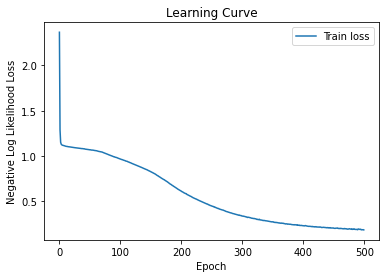

Final train NLL loss: 0.18756346192770024
Accuracy ratio: 475/500
Accuracy: 0.95
Your code PASSED the code check!


In [ ]:
from sklearn.datasets import make_gaussian_quantiles

def TEST_neural_network():
    
    def onehot(y):
        n_values = np.max(y) + 1
        oh = np.eye(n_values)[y.flatten()]
        return oh
    
    nn_clf = NeuralNetwork(    
        neurons_per_layer=[10, 10, 10, 3],
        g_hidden=ReLU,
        g_output=Softmax,
        batch_size=64, 
        epochs=500,
        alpha=.01,
        verbose=True
    )
    
    X, y = make_gaussian_quantiles(
        cov=1, 
       n_samples=500, 
       n_features=3, 
       n_classes=3, 
       random_state=42
    )
    
    y = onehot(y)
    ss = Standardization()
    X = ss.fit_transform(X)
    
    nn_clf.fit(X, y)
    y_hat = nn_clf.predict(X)

    
    plt.plot(nn_clf.avg_trn_loss_tracker, label='Train loss')
    plt.title("Learning Curve")
    plt.ylabel("Negative Log Likelihood Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
    y_hat_probs = nn_clf.predict_proba(X)
    nll_loss = nll(y=y, y_hat_probs=y_hat_probs) / len(y)
    print(f"Final train NLL loss: {nll_loss}")
    acc = accuracy(y=y, y_hat=y_hat)
    print(f"Accuracy: {acc}")

    todo_check([
        (np.all(np.isclose(nn_clf.nn[0].W[0, :3],np.array([0.04373074, 0.60476897, 0.14050529]),rtol=.01)), "Weight values for the 1st hidden layer are incorrect"),
        (np.isclose(nll_loss, 0.1875, rtol=.01), 'nll_loss is incorrect'),
    ])

    
TEST_neural_network()
garbage_collect(['TEST_neural_network'])

# Non-linear Multi-Class Classification

Finally, onto training! Let's now use the full Sign Language MNIST dataset to test the our neural network implementation.

## Training

###  Cross validation and Hyper-parameter Tuning

Training this time around is going to be different. In this lab, we are going to be using *cross validation*. Doing so will help us to find the optimal hyper-parameters for our neural network.

#### K-cross validation

To understand how cross validation with hyper-parameter tuning works, we first need to understand *[K-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/)* which acts as the core concept that cross validation is built upon. 

The idea of k-fold validation is to split your dataset into $k$ folds. Each fold then takes turns acting as the test dataset while the rest are combined to act as the training dataset. We do this for all combinations of folds. This means each fold acts as the test dataset once. We refer to the different combinations of training and test datasets as *splits*.

The below image is an example of using $k=5$ such that we split the training data into 5 folds. Thus, we train the model using 5 different splits. Meaning, we train the model 5 times, once for each unique test dataset.

Once k-fold validation is done, we compute the average over ALL test metrics. Doing so gives us a good idea how of our model (i.e., neural network in this case) will perform when using different training and test data.


#### Cross validation with Hyper-parameter Tuning
[*Hyper-parameter cross validation*](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) uses k-cross validation with hyper-parameter tuning. Hyper-parameter tuning entails training using different combinations of hyper-parameters where the goal is to find "optimal" hyper-parameters for the current problem. 

One form of cross validation modifies k-cross validation using *grid search*. Grid search works by training a model multiple times using all combinations of any specified hyper-parameters. Thus, cross validation with grid search performs a grid search over hyper-parameters for each split (see the below picture).

For example, say we had $k=5$ and we wanted to choose the best learning rate using the values {.01, .001} and best mini-batch size using the values {32, 64, 128}. Each split would need to train the model 6 times as we have 2 learning rates values and 3 mini-batch size values, leading to $2*3=6$ combinations of hyper-parameters to search over. Further, we would have to train the model 30 times in total as there are 5 splits and 6 different hyper-parameter combinations such that $5*6=30$.

While cross validation can help us find the optimal hyper-parameters, it can be very expensive as you add more and more hyper-parameters to test. Doing so, means the number of hyper-parameter combinations to search over grows as well. As you might imagine, this becomes very computationally expensive.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fscikit-learn.org%2Fstable%2F_images%2Fgrid_search_cross_validation.png&f=1&nofb=1" width=400 height=400>

#### TODO 14
Complete this TODO by finishing the `run_neural_network_cv()` which performs cross validation with grid search by utilizing Sklearn's `GridSearchCV` class.

**Initialize a dummy `NeuralNetwork` class instance**

Before we can create the `GridSearchCV` class, the `GridSearchCV` requires that we initialize a dummy instance of our model/estimator. In this case, our model is a neural network which we defined in the `NeuralNetwork` class above. To make a dummy instance we simply initialize the `NeuralNetwork` class as we would normally, however the values for the arguments we pass don't matter as the `GridSearchCV` class will override them later on. Thus, we can simply pass `None` or any random argument values to any required arguments for our `NeuralNetwork` class.

1. Initialize a dummy/placeholder instance of the `NeuralNetwork` class by passing `None` to all required arguments. Store the output into `nn_clf`.


**Initialize `Scorer` class instance**

A `Scorer` is a Sklearn specific class that wraps performance metrics like accuracy or a loss function so that they are compatible with `GridSearchCV`. `GridSearchCV` then uses these `Scorer` class instances to measure the performance of each split and hyper-parameter combination.

2. Initialize an instance of Sklearn's `Scorer` class using the `make_scorer()` function ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)). To do so, pass the arguments that meet the following description:
    1. Pass a **reference** of the `mean_nll` function to the `score_func` argument. We will use the mean of the NLL loss computed by the `mean_nll()` function to measure the performance of the model for each split.
    1. Pass the argument that indicates that `score_func` requires the use of the `predict_proba()` method. Recall, the  `predict_proba()` in the `NeuralNetwork` class will return the probabilities.
    1. Pass the argument that indicates `score_func` is a loss function so that a lower score will indicate the model is performing better. Meaning, greater loss is NOT better, it is worse! 
        1. Note: By passing this argument the scores output by the `GridSearchCV` will actually be negative!
    
**Initialize `GridSearchCV` class instance**

`GridSearchCV` performs an exhaustive search over specified parameter values for our estimator `NeuralNeworks`. The specified parameters are passed to the `param_grid` argument when initializing a `GridSearchCV` class instance.

3. Finish the initialization of the instance for Sklearn's `GridSearchCV` class ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)). Store the output into `gscv`. To do so, pass the arguments that meet the following description:
    1. Pass our placeholder/dummy `NeuralNetwork` class instance to the `estimator` argument which we defined in TODO 14.1.
    2. Pass the `nn_param_grid` argument taken in by our `run_neural_network_cv()` function to the `param_grid` argument. `nn_param_grid` will contain the hyper-parameters to perform the grid search over.
    3. Pass our `Scorer` class instance to the `scoring` argument.
    4. Tell `GridSearchCV` to split our data into 2 folds or $k=2$ by setting the `cv` argument.
    
**Defining hyper-parameters to search**

When defining `nn_param_grid`, which defines the hyper-parameters to search over, for our `NeuralNetwork` class you have to follow the rules given below:

- First, `nn_param_grid` must be a dictionary where the keys correspond to the string names of the arguments taken in by the `NeuralNetwork.__init__()` method. 
- Second, the values of the dictionary must be a **list** as each element in the list will be a value used by the grid search. If you simply want `GridSearchCV` to use a single value for a particular hyper-parameter then pass a list with one element.

Below is an example of how you could set `nn_param_grid`. Notice, each key corresponds to an argument in `NeuralNetwork.__init__()`. Further notice, all values are lists and some values such as  `neurons_per_layer`, `batch_size`, and `epochs` have multiple elements. Each element corresponds to a new value for the hyper-parameter that will be used in the grid search. Thus, each split would train our `NeuralNetwork` class 8 times as there is a total 8 hyper-parameter combinations ($2*2*2=8$). 
    
```Python
nn_param_grid = dict(
    neurons_per_layer=[[5, 5, 24], [20, 24]],
    g_hidden=[ReLU],
    g_output=[Softmax],
    batch_size=[64, 256], 
    epochs=[15, 40],
    alpha=[.01]
)
```


4. Fill in the dictionary of keyword arguments that correspond to the `NeuralNetwork` class. Select hyper-parameters YOU want to try searching over. Store the output into `nn_param_grid`.
    1. Hint: Try to limit the number of hyper-parameters you search over. The more values you try searching over the longer cross validation will take!

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def mean_nll(y, y_hat_probs):
    """ Computes the mean loss of the NLL loss function"""
    return nll(y=y, y_hat_probs=y_hat_probs) / len(y)

def run_neural_network_cv(
    X: np.ndarray, 
    y: np.ndarray, 
    nn_param_grid: dict
) -> GridSearchCV:
    """ Perform cross validation with hyper-parameter tuning using the NeuralNetwork class
    
        Args:
            X: Data to be used for nest cross validation
            
            y: Labels which correspond to the data
            
            nn_param_grid:  Dictionary containg the hyper-parameters 
                to perform the grid search over. These correspond
                to the arguments taken in by the 
                NeuralNetwork.__init__() method.
    
    """
    # TODO 14.1
    nn_clf = 
    
    # TODO 14.2
    mean_nll_scorer =
    
    # TODO 14.3
    gscv = 
    
    gscv.fit(X_trn, y_trn)
    
    return gscv

In [ ]:
# TODO 14.4
nn_param_grid =

gscv = run_neural_network_cv(
    X=X_trn,
    y=y_trn,
    nn_param_grid=nn_param_grid
)

todo_check([
    (np.all([isinstance(v, (list, tuple)) for v in nn_param_grid.values()]), "nn_param_grid keys whose values are lists or tuples."),
    (isinstance(gscv.estimator, NeuralNetwork), "gscv.estimator does not contain an instance of our NeuralNetwork class. "),
])

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END alpha=0.01, batch_size=64, epochs=15, g_hidden=<class '__main__.ReLU'>, g_output=<class '__main__.Softmax'>, neurons_per_layer=[10, 10, 24];, score=-1.946 total time=   3.9s
[CV 2/2] END alpha=0.01, batch_size=64, epochs=15, g_hidden=<class '__main__.ReLU'>, g_output=<class '__main__.Softmax'>, neurons_per_layer=[10, 10, 24];, score=-1.984 total time=   3.6s
[CV 1/2] END alpha=0.01, batch_size=64, epochs=15, g_hidden=<class '__main__.ReLU'>, g_output=<class '__main__.Softmax'>, neurons_per_layer=[20, 24];, score=-0.881 total time=   1.8s
[CV 2/2] END alpha=0.01, batch_size=64, epochs=15, g_hidden=<class '__main__.ReLU'>, g_output=<class '__main__.Softmax'>, neurons_per_layer=[20, 24];, score=-0.858 total time=   2.7s
[CV 1/2] END alpha=0.01, batch_size=64, epochs=40, g_hidden=<class '__main__.ReLU'>, g_output=<class '__main__.Softmax'>, neurons_per_layer=[10, 10, 24];, score=-1.206 total time=   5.1s
[CV 2/2] END 

The results of the Sklearn's `GridSearchCV` are stored in the `cv_results_` variable as a dictionary. You can read about how properly understand thee `cv_results_` variable output by looking at the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
gscv.cv_results_

{'mean_fit_time': array([3.6612376 , 2.18145335, 5.12602258, 5.55651188, 1.02354932,
        1.45234978, 3.55129588, 3.61385918]),
 'std_fit_time': array([0.13909733, 0.44947851, 0.07561922, 0.89718699, 0.10103726,
        0.07913458, 0.17853081, 0.44184542]),
 'mean_score_time': array([0.0691359 , 0.06634855, 0.07164216, 0.05644608, 0.05293369,
        0.08360517, 0.0684489 , 0.05341721]),
 'std_score_time': array([0.00970769, 0.00229311, 0.01107144, 0.00134659, 0.00112176,
        0.00827038, 0.00403559, 0.00087523]),
 'param_alpha': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_batch_size': masked_array(data=[64, 64, 64, 64, 256, 256, 256, 256],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[15, 15, 40, 40, 15,

However, notice reading these results is really hard. We can format these results in a more digestible form by converting them into a Pandas DataFrame. The below function `format_results()` does exactly this. Further, it applies so additional formating steps for you to make results easier to interpret.

In [ ]:
def format_results(search_results):
    def get_name(obj):
        try:
            if hasattr(obj, '__name__'):
                return obj.__name__
            elif hasattr(obj, '_name'):
                return obj._name
            elif hasattr(obj, 'name'):
                return obj.name
            else:
                return obj
        except Exception as e:
            return obj

    def find_name(objs):
        if isinstance(objs, (tuple, list)):
            obj_names = []
            for obj in objs:
                name = get_name(obj)
                obj_names.append(name)
            return obj_names
        else:
            return get_name(objs)
       
    df = pd.DataFrame(search_results)
    # Remove train related scores
    df.drop(list(df.filter(regex='train')), axis=1, inplace=True)
    # Sort results performance rank
    df.sort_values('rank_test_score', axis=0, inplace=True)
    df.reset_index(inplace=True, drop=True)
    # Convert object references to readable string names
    df = df.applymap(find_name)
    # Remove params column
    df.drop('params', axis=1, inplace=True)
    # Move rank_test_score to the first column
    rts = df.pop('rank_test_score')
    df.insert(0, rts.name, rts)

    return df

Below we format `gscv.cv_results_` using the `format_results()` function and store the output into `search_results`. Recall, `search_results` is a DataFrame and can be read as follows:

- The `rank_test_score` column gives the rank for the performance of the hyper-parameter combination. Here the value of '1' indicates the hyper-parameter combination with the lowest mean test NLL loss computed over all splits. Further notice, the `search_results` DataFrame is sorted by rank.

- Any column with the `_time` postfix provides statistics about how long it took to train and test using ALL splits for a given hyper-parameter combination.

- Any column with the `param_` prefix denotes the hyper-parameter value for a given hyper-parameter combination.

- Any column with the `split` prefix provides statistics regarding the performance of a given hyper-parameter combination for a particular split.

- The `mean_test_score` reports the average test score over ALL splits for a given hyper-parameter combination. This is score that rank is determined by and the score you want to pay the most attention to!
    - Recall test scores correspond to the metric passed to the `scoring` argument when initializing a `GridSearchCV` class instance. In our case, our test score is the mean NLL loss.

- The `std_test_score` reports the standard deviation for `mean_test_score`.


Notice, the mean test scores are all negative! This is because we specified the `greater_is_better=False` argument when defining our `scorer` variable. By doing so, Sklearn changes all scores to negative, This is just a weird and confusing thing Sklearn does that relates to making generalizable code. However, by making all the scores negative it just means when you take the max, the largest negative, in turn smallest loss, is the value closest to zero.

In [ ]:
search_results = format_results(gscv.cv_results_)
search_results

,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_batch_size,param_epochs,param_g_hidden,param_g_output,param_neurons_per_layer,split0_test_score,split1_test_score,mean_test_score,std_test_score
0,1,5.556512,0.897187,0.056446,0.001347,0.01,64,40,ReLU,Softmax,"[20, 24]",-0.377615,-0.360607,-0.369111,0.008504
1,2,2.181453,0.449479,0.066349,0.002293,0.01,64,15,ReLU,Softmax,"[20, 24]",-0.881427,-0.858059,-0.869743,0.011684
2,3,3.613859,0.441845,0.053417,0.000875,0.01,256,40,ReLU,Softmax,"[20, 24]",-1.101291,-1.066090,-1.083690,0.017601
3,4,5.126023,0.075619,0.071642,0.011071,0.01,64,40,ReLU,Softmax,"[10, 10, 24]",-1.205687,-1.179020,-1.192353,0.013333
4,5,1.452350,0.079135,0.083605,0.008270,0.01,256,15,ReLU,Softmax,"[20, 24]",-1.754719,-1.704370,-1.729545,0.025174
5,6,3.661238,0.139097,0.069136,0.009708,0.01,64,15,ReLU,Softmax,"[10, 10, 24]",-1.945726,-1.984289,-1.965008,0.019281
6,7,3.551296,0.178531,0.068449,0.004036,0.01,256,40,ReLU,Softmax,"[10, 10, 24]",-2.268992,-2.303381,-2.286186,0.017194
7,8,1.023549,0.101037,0.052934,0.001122,0.01,256,15,ReLU,Softmax,"[10, 10, 24]",-2.860336,-2.877670,-2.869003,0.008667


## Validation Evaluation

#### TODO 15
Using the nest cross validation above, complete this TODO by selecting the hyper-parameters and training a neural network that produces a validation NLL loss below 0.25. 

1. Fill in the `nn_hyper_params` dictionary with the hyper-parameters for our `NeuralNetwork` class that YOU think will allow achieve a validation NLL loss below 0.25. Each key of the dictionary should match the keyword argument in the `NeuralNetwork.__init__()` method.
    1. Hint: Use the learning curve plot that is plotted at the end of the training to help select how many epochs you need to prevent overfitting. Refer to this [post](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).
    1. Note: Recall, a dictionary's keys and values can be "unloaded" into class or function to act as keyword arguments (see this [post](https://www.pythontutorial.net/python-basics/python-kwargs/) for more details) 

Epoch: 1
	Training loss: 4.064117561442893
	Validation loss: 2.4516379821109133
Epoch: 2
	Training loss: 1.9575994259665532
	Validation loss: 1.6953541538090315
Epoch: 3
	Training loss: 1.4840888023010008
	Validation loss: 1.3922374014082024
Epoch: 4
	Training loss: 1.2592520131513354
	Validation loss: 1.220552968849474
Epoch: 5
	Training loss: 1.1116008921830554
	Validation loss: 1.0999218202572234
Epoch: 6
	Training loss: 0.9984431999936776
	Validation loss: 0.99436610161622
Epoch: 7
	Training loss: 0.9056080417440157
	Validation loss: 0.9043593917028474
Epoch: 8
	Training loss: 0.8271674806441326
	Validation loss: 0.8364702825222821
Epoch: 9
	Training loss: 0.7591500840658397
	Validation loss: 0.7623183956498921
Epoch: 10
	Training loss: 0.6992988682676936
	Validation loss: 0.7070611709415838
Epoch: 11
	Training loss: 0.6448141964914981
	Validation loss: 0.656360761542101
Epoch: 12
	Training loss: 0.5968045657274607
	Validation loss: 0.6069801963466634
Epoch: 13
	Training loss: 0.55

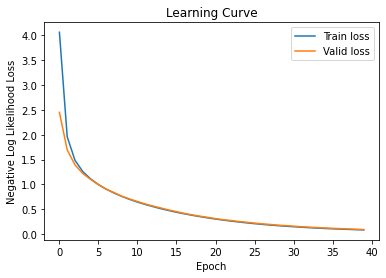

--------------------------------------------------
Valid NLL loss: 0.09226542000363934
Your code PASSED the code check!


In [ ]:
# TODO 15.1
nn_hyper_params =

nn_clf = NeuralNetwork(**nn_hyper_params)

nn_clf.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)

plt.plot(nn_clf.avg_trn_loss_tracker, label='Train loss')
plt.plot(nn_clf.avg_vld_loss_tracker, label='Valid loss')
plt.title("Learning Curve")
plt.ylabel("Negative Log Likelihood Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

y_hat_probs_vld = nn_clf.predict_proba(X_vld)
vld_nll = mean_nll(y=y_vld, y_hat_probs=y_hat_probs_vld)
print("-"*50)
print(f"Valid NLL loss: {vld_nll}")

todo_check([
    (vld_nll <= 0.25, "vld_nll loss is not below .25")
])

In [ ]:
y_hat_vld= nn_clf.predict(X_vld)
class_labels[y_hat_vld]

array([[24],
       [ 8],
       [18],
       ...,
       [ 0],
       [20],
       [ 3]])

In [ ]:
accuracy(y=y_vld, y_hat=y_hat_vld)

Accuracy ratio: 5446/5491


0.9918047714441813

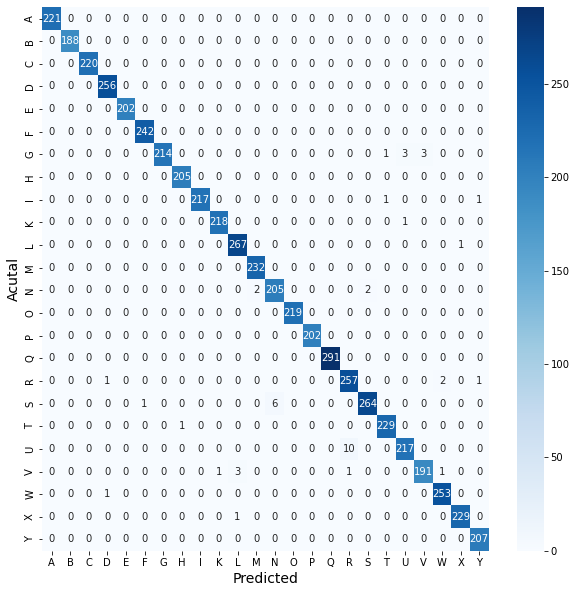

In [ ]:
plot_confusion_matrix(
    y_hat=class_labels[y_hat_vld], 
    y=class_labels[np.argmax(y_vld, axis=1)],
    class_names=class_names,
    figsize=(10,10)
);

## Testing Evaluation

Let's now see how well the neural network trained using your selected hyper-parameters, stored in `nn_hyper_params`, performs on the testing set. To do so, we will retrain a neural network using a combined dataset consisting of the train and validation datasets. Further, we'll track the loss over each epoch for the new combined training dataset and the testing dataset.

In [ ]:
X_trn_all = np.vstack([X_trn, X_vld])
y_trn_all = np.vstack([y_trn, y_vld])

nn_clf = NeuralNetwork(**nn_hyper_params)

nn_clf.fit(X_trn_all, y_trn_all, X_vld=X_tst, y_vld=y_tst)

Epoch: 1
	Training loss: 3.700918691469061
	Validation loss: 2.441375246831003
Epoch: 2
	Training loss: 1.7299916576883247
	Validation loss: 1.861992438121463
Epoch: 3
	Training loss: 1.3303369313705782
	Validation loss: 1.723804100760098
Epoch: 4
	Training loss: 1.1274478662773386
	Validation loss: 1.6408203241277286
Epoch: 5
	Training loss: 0.9857356619621288
	Validation loss: 1.5623410122642392
Epoch: 6
	Training loss: 0.8736546205296861
	Validation loss: 1.5483597917284966
Epoch: 7
	Training loss: 0.7806138649222859
	Validation loss: 1.5303810760453185
Epoch: 8
	Training loss: 0.7023501006590129
	Validation loss: 1.5025918365501278
Epoch: 9
	Training loss: 0.6347154115208026
	Validation loss: 1.517672698175924
Epoch: 10
	Training loss: 0.5752465215631112
	Validation loss: 1.5164857479841696
Epoch: 11
	Training loss: 0.5230607120094011
	Validation loss: 1.5133701796366321
Epoch: 12
	Training loss: 0.47554929303420507
	Validation loss: 1.5504786962762072
Epoch: 13
	Training loss: 0.4

You might be noticing, depending on the hyper-parameters you picked, that you have vastly overfitted to the training and validation datasets! You can tell as your learning curve will show your test loss start to increase while the training loss continues to decrease and by having a very low test accuracy (if you want to learn more checkout this [post](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) on interpreting learning curves). This is an example where picking the best hyper-parameters doesn't mean your model will generalize well to new unseen data. 

Overcoming this problem is non-trivial. However, to help alleviate this issue, we would likely need to diversify the training dataset to account for the variations in testing data that are not included in the training or validation datasets. 

That being said, a short term fix could be simply training less epochs and stopping training before the validation loss starts to increase. Doing so is what we call *[early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/)*.

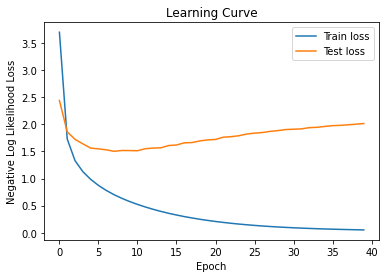

In [ ]:
plt.plot(nn_clf.avg_trn_loss_tracker, label='Train loss')
plt.plot(nn_clf.avg_vld_loss_tracker, label='Test loss')
plt.title("Learning Curve")
plt.ylabel("Negative Log Likelihood Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
tst_nll = mean_nll(y_tst, nn_clf.predict_proba(X_tst))
print(f"Test NLL loss: {tst_nll}")

Test NLL loss: 2.0153347704989533


In [ ]:
y_hat_tst= nn_clf.predict(X_tst)
class_labels[y_hat_tst]

array([[ 6],
       [ 5],
       [10],
       ...,
       [ 2],
       [ 4],
       [ 2]])

In [ ]:
accuracy(y=y_tst, y_hat=y_hat_tst)

Accuracy ratio: 4309/7172


0.600808700501952

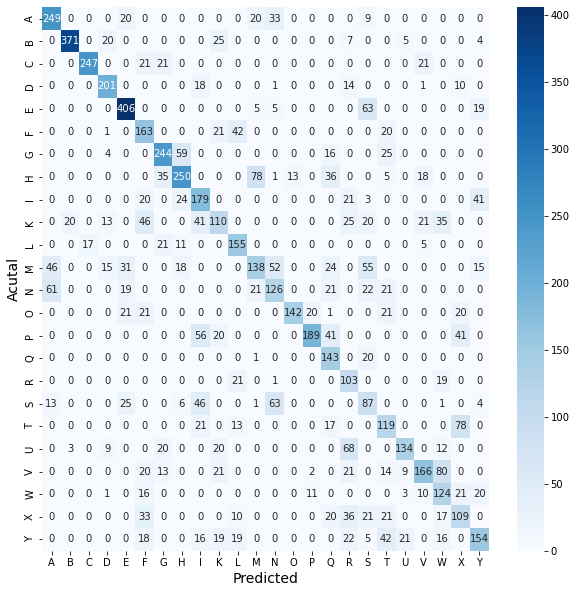

In [ ]:
plot_confusion_matrix(
    y_hat=class_labels[y_hat_tst], 
    y=class_labels[np.argmax(y_tst, axis=1)],
    class_names=class_names,
    figsize=(10,10)
);